Train and score a boosted decision tree model using [LightGBM Python package](https://github.com/Microsoft/LightGBM) from Microsoft, which is a fast, distributed, high performance gradient boosting framework based on decision tree algorithms.  

In [1]:
import os
import sys
import math
import itertools
import datetime
import random
import numpy as np
import pandas as pd
import lightgbm as lgb 
from sklearn.model_selection import train_test_split

In [2]:
# Append TSPerf path to sys.path
nb_dir = os.path.split(os.getcwd())[0]
tsperf_dir = os.path.dirname(os.path.dirname(os.path.dirname(nb_dir)))
if tsperf_dir not in sys.path:
    sys.path.append(tsperf_dir)

from common.metrics import MAPE
import retail_sales.OrangeJuice_Pt_3Weeks_Weekly.common.benchmark_settings as bs

In [3]:
# Data paths
DATA_DIR = '../../data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Parameters of GBM model
params = {
    'num_leaves': 50, 
    'objective': 'mape', 
    'min_data_in_leaf': 200, 
    'learning_rate': 0.002, 
    'feature_fraction': 0.9, 
    'bagging_fraction': 0.7,
    'bagging_freq': 1,
    'num_threads': 16,
    'early_stopping_rounds': 125,
    'verbose_eval': 20
}
# Note that 800 boost rounds is used in this notebook. After checking the training 
# and validation MAPEs, this number is set to be 400 in the submission script.
MAX_ROUNDS = 800 #400 #100 

# Lags and categorical features
lags = [2,3,4] 
categ_fea = ['store', 'brand', 'deal', 'feat'] 

In [4]:
# Utility functions
def week_of_month(dt):
    """Get the week of the month for the specified date.
    
    Args: 
        dt (Datetime): Input date
        
    Returns:
        wom (Integer): Week of the month of the input date
    """ 
    from math import ceil
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    wom = int(ceil(adjusted_dom/7.0))
    return wom

def df_from_cartesian_product(dict_in):
    """Generate a Pandas dataframe from Cartesian product of lists.
    
    Args: 
        dict_in (Dictionary): Dictionary containing multiple lists
        
    Returns:
        df (Dataframe): Dataframe corresponding to the Caresian product of the lists
    """
    from collections import OrderedDict
    from itertools import product
    od = OrderedDict(sorted(dict_in.items()))
    cart = list(product(*od.values()))
    df = pd.DataFrame(cart, columns=od.keys())
    return df

def lagged_features(df, lags):
    """Create lagged features based on time series data.
    
    Args:
        df (Dataframe): Input time series data sorted by time
        lags (List): Lag lengths
        
    Returns:
        fea (Dataframe): Lagged features 
    """
    df_list = []
    for lag in lags:
        df_shifted = df.shift(lag)
        df_shifted.columns = [x + '_lag' + str(lag) for x in df_shifted.columns]
        df_list.append(df_shifted)
    fea = pd.concat(df_list, axis=1)
    return fea

def moving_averages(df, start_step, window_size=None):
    """Compute averages of every feature over moving time windows.
    
    Args:
        df (Dataframe): Input features as a dataframe
    
    Returns:
        fea (Dataframe): Dataframe consisting of the moving averages
    """
    if window_size == None: # Use a large window to compute average over all historical data
        window_size = df.shape[0]
    fea = df.shift(start_step).rolling(min_periods=1, center=False, window=window_size).mean()
    fea.columns = fea.columns + '_mean'
    return fea

def create_features(df, lags):
    """Create features used for model training.
    
    Args:
        df (Dataframe): Time series data of a certain store and brand
        lags (List): Lag lengths
    
    Returns:
        fea_all (Dataframe): All features for the specific store and brand
    """
    lagged_fea = lagged_features(df[['move']], lags)
    moving_avg = moving_averages(df[['move']], 2, 10)
    fea_columns = ['brand', 'store', 'week', 'week_of_month', 'day', 'deal', 'feat', 'move']
    #fea_columns = fea_columns + ['price1', 'price2', 'price3', 'price4', 'price5', 'price6', 'price7', 'price8', 'price9', 'price10', 'price11']
    fea_all = pd.concat([df[fea_columns], lagged_fea, moving_avg], axis=1)
    return fea_all

def make_predictions(df, model):
    """Predict sales with the trained GBM model.
    
    Args: 
        df (Dataframe): Dataframe including all needed features
        model (Model): Trained GBM model
        
    Returns:
        Dataframe including the predicted sales of a certain store and brand
    """
    predictions = pd.DataFrame({'move': model.predict(df.drop('move', axis=1))})
    predictions['move'] = predictions['move'].apply(lambda x: round(x))
    return pd.concat([df[['brand', 'store', 'week']].reset_index(drop=True), predictions], axis=1)

def evaluate(result):
    """Compute MAPE value of the forecast.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
    
    Returns:
        MAPE value of the forecast
    """
    return MAPE(result['move'], result['actual'])*100

def plot_result(results, store, brand):
    """Plot out prediction results and actual sales.
    
    Args:
        result (Dataframe): Input dataframe including predicted sales and actual sales
        store (integer): store index
        brand (integer): brand index
        
    Returns:
        None
    """
    subset = results[(results.store==store) & (results.brand==brand)]
    subset = subset[['week', 'move', 'actual']].set_index('week')
    #print(subset)
    print('Sample MAPE is {}'.format(evaluate(subset)))
    plt.figure()
    ax = subset.plot()
    ax.set_ylim(bottom=0)
    ax.legend(labels=['predicted', 'actual'])

In [5]:
# Train and predict for all forecast rounds
pred_all = []
combined_all = []
metric_all = []
for r in range(bs.NUM_ROUNDS): 
    print('---- Round ' + str(r+1) + ' ----')
    train_df = pd.read_csv(os.path.join(TRAIN_DIR, 'train_round_'+str(r+1)+'.csv'))
    train_df['move'] = train_df['logmove'].apply(lambda x: round(math.exp(x)))
    train_df.drop('logmove', axis=1, inplace=True)
    print(train_df.head(3))
    print('')
    # Fill missing values
    store_list = train_df['store'].unique()
    brand_list = train_df['brand'].unique()
    week_list = range(bs.TRAIN_START_WEEK, bs.TEST_END_WEEK_LIST[r]+1)
    d = {'store': store_list,
         'brand': brand_list,
         'week': week_list}        
    data_grid = df_from_cartesian_product(d)
    data_filled = pd.merge(data_grid, train_df, how='left', 
                            on=['store', 'brand', 'week'])
    print('Number of missing rows is {}'.format(data_filled[data_filled.isnull().any(axis=1)].shape[0]))
    print('')
    data_filled = data_filled.groupby(['store', 'brand']). \
                              apply(lambda x: x.fillna(method='ffill').fillna(method='bfill'))
    # Create datetime features
    data_filled['week_start'] = data_filled['week'].apply(lambda x: bs.FIRST_WEEK_START + datetime.timedelta(days=(x-1)*7))
    data_filled['year'] = data_filled['week_start'].apply(lambda x: x.year)
    data_filled['month'] = data_filled['week_start'].apply(lambda x: x.month)
    data_filled['week_of_month'] = data_filled['week_start'].apply(lambda x: week_of_month(x))
    data_filled['day'] = data_filled['week_start'].apply(lambda x: x.day)
    data_filled.drop('week_start', axis=1, inplace=True)
    # Create other features (lagged features, moving averages, etc.)
    features = data_filled.groupby(['store','brand']). \
                           apply(lambda x: create_features(x, lags))
    train_fea = features[features.week <= bs.TRAIN_END_WEEK_LIST[r]].reset_index(drop=True)
    print('Maximum training week number is {}'.format(max(train_fea['week'])))
    print('')
    # Drop rows with NaN values
    train_fea.dropna(inplace=True)
    print(train_fea.head(1))
    print('')
    print('Training and predicting models...')
    evals_result = {} # to record eval results for plotting
    # Create a training/validation split
    train_fea, valid_fea, train_label, valid_label = train_test_split(train_fea.drop('move', axis=1, inplace=False), \
                                                                  train_fea['move'], test_size=0.2, random_state=1)
    dtrain = lgb.Dataset(train_fea, train_label)
    dvalid = lgb.Dataset(valid_fea, valid_label)
    # Train GBM model
    bst = lgb.train(
        params, 
        dtrain, 
        num_boost_round = MAX_ROUNDS,
        valid_sets = [dtrain, dvalid], 
        categorical_feature = categ_fea, 
        evals_result = evals_result
    )
    # Generate forecasts
    test_fea = features[features.week >= bs.TEST_START_WEEK_LIST[r]].reset_index(drop=True)
    pred = make_predictions(test_fea, bst). \
           sort_values(by=['store','brand', 'week']). \
           reset_index(drop=True)
    # Additional columns required by the submission format
    pred['round'] = r+1
    pred['weeks_ahead'] = pred['week'] - bs.TRAIN_END_WEEK_LIST[r]
    print(pred)
    print('')
    # Evaluate prediction accuracy
    test_df = pd.read_csv(os.path.join(TEST_DIR, 'test_round_'+str(r+1)+'.csv'))
    test_df['actual'] = test_df['logmove'].apply(lambda x: round(math.exp(x)))
    test_df.drop('logmove', axis=1, inplace=True)
    combined = pd.merge(pred, test_df, on=['store', 'brand', 'week'], how='left')
    metric_value = evaluate(combined)
    print('')
    print('MAPE of current round is {}'.format(metric_value))
    print('')
    # Keep the predictions and accuracy
    pred_all.append(pred)
    combined_all.append(combined)
    metric_all.append(metric_value)

# Generate submission
submission = pd.concat(pred_all, axis=0)
submission.rename(columns={'move': 'prediction'}, inplace=True)
submission = submission[['round', 'store', 'brand', 'week', 'weeks_ahead', 'prediction']]
#submission.to_csv('submission.csv', index=False)

---- Round 1 ----
   store  brand  week  constant    price1    price2    price3    price4  \
0      2      1    40         1  0.060469  0.060497  0.042031  0.029531   
1      2      1    46         1  0.060469  0.060312  0.045156  0.046719   
2      2      1    47         1  0.060469  0.060312  0.045156  0.046719   

     price5    price6    price7    price8    price9   price10   price11  deal  \
0  0.049531  0.053021  0.038906  0.041406  0.028906  0.024844  0.038984     1   
1  0.049531  0.047813  0.045781  0.027969  0.042969  0.042031  0.038984     0   
2  0.037344  0.053021  0.045781  0.041406  0.048125  0.032656  0.038984     0   

   feat     profit  move  
0   0.0  37.992326  8256  
1   0.0  30.126667  6144  
2   0.0  30.000000  3840  

Number of missing rows is 6204

Maximum training week number is 135

   brand  store  week  week_of_month  day  deal  feat    move  move_lag2  \
4      1      2    44              3   12   1.0   0.0  8256.0     8256.0   

   move_lag3  move_lag4  

/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/engine.py:107: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is ['brand', 'deal', 'feat', 'store']
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/home/chenhui/.local/lib/python3.5/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


[2]	training's mape: 0.779309	valid_1's mape: 0.774364
[3]	training's mape: 0.778335	valid_1's mape: 0.773412
[4]	training's mape: 0.777368	valid_1's mape: 0.772463
[5]	training's mape: 0.776428	valid_1's mape: 0.771541
[6]	training's mape: 0.775457	valid_1's mape: 0.770599
[7]	training's mape: 0.774513	valid_1's mape: 0.769673
[8]	training's mape: 0.773523	valid_1's mape: 0.76871
[9]	training's mape: 0.772557	valid_1's mape: 0.76777
[10]	training's mape: 0.771595	valid_1's mape: 0.766825
[11]	training's mape: 0.770643	valid_1's mape: 0.765885
[12]	training's mape: 0.769673	valid_1's mape: 0.764927
[13]	training's mape: 0.768691	valid_1's mape: 0.763971
[14]	training's mape: 0.767732	valid_1's mape: 0.763037
[15]	training's mape: 0.76677	valid_1's mape: 0.762097
[16]	training's mape: 0.765849	valid_1's mape: 0.761196
[17]	training's mape: 0.764906	valid_1's mape: 0.760272
[18]	training's mape: 0.763935	valid_1's mape: 0.759334
[19]	training's mape: 0.763	valid_1's mape: 0.758418
[20]	t

[149]	training's mape: 0.660084	valid_1's mape: 0.65799
[150]	training's mape: 0.659481	valid_1's mape: 0.657422
[151]	training's mape: 0.658808	valid_1's mape: 0.656765
[152]	training's mape: 0.658162	valid_1's mape: 0.656139
[153]	training's mape: 0.657519	valid_1's mape: 0.655524
[154]	training's mape: 0.656858	valid_1's mape: 0.654879
[155]	training's mape: 0.656221	valid_1's mape: 0.654255
[156]	training's mape: 0.655576	valid_1's mape: 0.653628
[157]	training's mape: 0.654942	valid_1's mape: 0.653017
[158]	training's mape: 0.654292	valid_1's mape: 0.652383
[159]	training's mape: 0.653639	valid_1's mape: 0.651752
[160]	training's mape: 0.652954	valid_1's mape: 0.651092
[161]	training's mape: 0.652332	valid_1's mape: 0.650496
[162]	training's mape: 0.651667	valid_1's mape: 0.649858
[163]	training's mape: 0.651021	valid_1's mape: 0.64924
[164]	training's mape: 0.650342	valid_1's mape: 0.648579
[165]	training's mape: 0.649786	valid_1's mape: 0.648052
[166]	training's mape: 0.649152	v

[296]	training's mape: 0.578043	valid_1's mape: 0.57809
[297]	training's mape: 0.577578	valid_1's mape: 0.577639
[298]	training's mape: 0.577119	valid_1's mape: 0.577191
[299]	training's mape: 0.576664	valid_1's mape: 0.57674
[300]	training's mape: 0.576233	valid_1's mape: 0.576321
[301]	training's mape: 0.575776	valid_1's mape: 0.575867
[302]	training's mape: 0.57532	valid_1's mape: 0.575428
[303]	training's mape: 0.574872	valid_1's mape: 0.574997
[304]	training's mape: 0.574382	valid_1's mape: 0.574516
[305]	training's mape: 0.573933	valid_1's mape: 0.574086
[306]	training's mape: 0.573469	valid_1's mape: 0.573624
[307]	training's mape: 0.57302	valid_1's mape: 0.573189
[308]	training's mape: 0.572599	valid_1's mape: 0.57277
[309]	training's mape: 0.572137	valid_1's mape: 0.572321
[310]	training's mape: 0.571696	valid_1's mape: 0.571885
[311]	training's mape: 0.571234	valid_1's mape: 0.571434
[312]	training's mape: 0.570798	valid_1's mape: 0.57101
[313]	training's mape: 0.570351	valid

[443]	training's mape: 0.520845	valid_1's mape: 0.522654
[444]	training's mape: 0.520543	valid_1's mape: 0.52236
[445]	training's mape: 0.520235	valid_1's mape: 0.522066
[446]	training's mape: 0.519912	valid_1's mape: 0.521747
[447]	training's mape: 0.519565	valid_1's mape: 0.521413
[448]	training's mape: 0.519253	valid_1's mape: 0.52111
[449]	training's mape: 0.518946	valid_1's mape: 0.520815
[450]	training's mape: 0.518634	valid_1's mape: 0.520517
[451]	training's mape: 0.518371	valid_1's mape: 0.520272
[452]	training's mape: 0.518077	valid_1's mape: 0.519989
[453]	training's mape: 0.517736	valid_1's mape: 0.519663
[454]	training's mape: 0.517427	valid_1's mape: 0.519367
[455]	training's mape: 0.517116	valid_1's mape: 0.51907
[456]	training's mape: 0.516853	valid_1's mape: 0.518822
[457]	training's mape: 0.516529	valid_1's mape: 0.518505
[458]	training's mape: 0.516213	valid_1's mape: 0.518193
[459]	training's mape: 0.515926	valid_1's mape: 0.517917
[460]	training's mape: 0.515631	va

[590]	training's mape: 0.480857	valid_1's mape: 0.484307
[591]	training's mape: 0.480648	valid_1's mape: 0.484114
[592]	training's mape: 0.480406	valid_1's mape: 0.483885
[593]	training's mape: 0.480187	valid_1's mape: 0.483677
[594]	training's mape: 0.479965	valid_1's mape: 0.483473
[595]	training's mape: 0.479762	valid_1's mape: 0.483285
[596]	training's mape: 0.479523	valid_1's mape: 0.48306
[597]	training's mape: 0.479282	valid_1's mape: 0.482833
[598]	training's mape: 0.479075	valid_1's mape: 0.482645
[599]	training's mape: 0.478838	valid_1's mape: 0.482418
[600]	training's mape: 0.478614	valid_1's mape: 0.482208
[601]	training's mape: 0.478374	valid_1's mape: 0.481975
[602]	training's mape: 0.478143	valid_1's mape: 0.481758
[603]	training's mape: 0.47793	valid_1's mape: 0.48156
[604]	training's mape: 0.477711	valid_1's mape: 0.481352
[605]	training's mape: 0.477519	valid_1's mape: 0.481173
[606]	training's mape: 0.477298	valid_1's mape: 0.480967
[607]	training's mape: 0.477098	va

[736]	training's mape: 0.453441	valid_1's mape: 0.458637
[737]	training's mape: 0.4533	valid_1's mape: 0.458505
[738]	training's mape: 0.453173	valid_1's mape: 0.458387
[739]	training's mape: 0.453036	valid_1's mape: 0.458256
[740]	training's mape: 0.452879	valid_1's mape: 0.458107
[741]	training's mape: 0.452723	valid_1's mape: 0.457959
[742]	training's mape: 0.452585	valid_1's mape: 0.457825
[743]	training's mape: 0.452429	valid_1's mape: 0.457679
[744]	training's mape: 0.452273	valid_1's mape: 0.457534
[745]	training's mape: 0.452129	valid_1's mape: 0.457409
[746]	training's mape: 0.451973	valid_1's mape: 0.457255
[747]	training's mape: 0.451822	valid_1's mape: 0.457118
[748]	training's mape: 0.451664	valid_1's mape: 0.456967
[749]	training's mape: 0.451519	valid_1's mape: 0.456833
[750]	training's mape: 0.451373	valid_1's mape: 0.456695
[751]	training's mape: 0.451222	valid_1's mape: 0.456547
[752]	training's mape: 0.451094	valid_1's mape: 0.456425
[753]	training's mape: 0.450945	v

[5]	training's mape: 0.775294	valid_1's mape: 0.766411
[6]	training's mape: 0.774329	valid_1's mape: 0.76548
[7]	training's mape: 0.773394	valid_1's mape: 0.764579
[8]	training's mape: 0.772401	valid_1's mape: 0.763611
[9]	training's mape: 0.771473	valid_1's mape: 0.762706
[10]	training's mape: 0.770531	valid_1's mape: 0.761787
[11]	training's mape: 0.769569	valid_1's mape: 0.760847
[12]	training's mape: 0.768604	valid_1's mape: 0.759907
[13]	training's mape: 0.767635	valid_1's mape: 0.758961
[14]	training's mape: 0.76668	valid_1's mape: 0.758044
[15]	training's mape: 0.765737	valid_1's mape: 0.757129
[16]	training's mape: 0.764805	valid_1's mape: 0.756219
[17]	training's mape: 0.763871	valid_1's mape: 0.755312
[18]	training's mape: 0.762921	valid_1's mape: 0.754386
[19]	training's mape: 0.761981	valid_1's mape: 0.753464
[20]	training's mape: 0.76104	valid_1's mape: 0.752542
[21]	training's mape: 0.76012	valid_1's mape: 0.751647
[22]	training's mape: 0.759205	valid_1's mape: 0.750767
[

[154]	training's mape: 0.657175	valid_1's mape: 0.651655
[155]	training's mape: 0.656555	valid_1's mape: 0.651061
[156]	training's mape: 0.655915	valid_1's mape: 0.650449
[157]	training's mape: 0.655254	valid_1's mape: 0.649817
[158]	training's mape: 0.654595	valid_1's mape: 0.649181
[159]	training's mape: 0.653939	valid_1's mape: 0.648548
[160]	training's mape: 0.653259	valid_1's mape: 0.647899
[161]	training's mape: 0.652678	valid_1's mape: 0.647343
[162]	training's mape: 0.651995	valid_1's mape: 0.646686
[163]	training's mape: 0.651345	valid_1's mape: 0.646063
[164]	training's mape: 0.650682	valid_1's mape: 0.645429
[165]	training's mape: 0.65012	valid_1's mape: 0.644882
[166]	training's mape: 0.649526	valid_1's mape: 0.644311
[167]	training's mape: 0.648942	valid_1's mape: 0.643746
[168]	training's mape: 0.6483	valid_1's mape: 0.643133
[169]	training's mape: 0.647682	valid_1's mape: 0.642528
[170]	training's mape: 0.64706	valid_1's mape: 0.641921
[171]	training's mape: 0.646471	val

[299]	training's mape: 0.577972	valid_1's mape: 0.575766
[300]	training's mape: 0.577539	valid_1's mape: 0.575356
[301]	training's mape: 0.577066	valid_1's mape: 0.574896
[302]	training's mape: 0.57664	valid_1's mape: 0.574488
[303]	training's mape: 0.576176	valid_1's mape: 0.574047
[304]	training's mape: 0.575716	valid_1's mape: 0.573609
[305]	training's mape: 0.575265	valid_1's mape: 0.573181
[306]	training's mape: 0.574819	valid_1's mape: 0.572747
[307]	training's mape: 0.574373	valid_1's mape: 0.572322
[308]	training's mape: 0.573947	valid_1's mape: 0.571913
[309]	training's mape: 0.573512	valid_1's mape: 0.571498
[310]	training's mape: 0.573049	valid_1's mape: 0.571049
[311]	training's mape: 0.572614	valid_1's mape: 0.570632
[312]	training's mape: 0.572177	valid_1's mape: 0.570221
[313]	training's mape: 0.571724	valid_1's mape: 0.569798
[314]	training's mape: 0.571284	valid_1's mape: 0.56938
[315]	training's mape: 0.570876	valid_1's mape: 0.568994
[316]	training's mape: 0.570446	v

[444]	training's mape: 0.52195	valid_1's mape: 0.522396
[445]	training's mape: 0.521617	valid_1's mape: 0.52208
[446]	training's mape: 0.521275	valid_1's mape: 0.521749
[447]	training's mape: 0.520987	valid_1's mape: 0.521484
[448]	training's mape: 0.520681	valid_1's mape: 0.521193
[449]	training's mape: 0.520372	valid_1's mape: 0.520902
[450]	training's mape: 0.520054	valid_1's mape: 0.520604
[451]	training's mape: 0.519777	valid_1's mape: 0.520345
[452]	training's mape: 0.519448	valid_1's mape: 0.520036
[453]	training's mape: 0.519126	valid_1's mape: 0.519725
[454]	training's mape: 0.518817	valid_1's mape: 0.51943
[455]	training's mape: 0.518497	valid_1's mape: 0.519122
[456]	training's mape: 0.518231	valid_1's mape: 0.518878
[457]	training's mape: 0.517905	valid_1's mape: 0.518561
[458]	training's mape: 0.517539	valid_1's mape: 0.518204
[459]	training's mape: 0.51726	valid_1's mape: 0.517942
[460]	training's mape: 0.516932	valid_1's mape: 0.51763
[461]	training's mape: 0.516636	vali

[590]	training's mape: 0.482444	valid_1's mape: 0.485035
[591]	training's mape: 0.482215	valid_1's mape: 0.484818
[592]	training's mape: 0.481973	valid_1's mape: 0.484587
[593]	training's mape: 0.481752	valid_1's mape: 0.48438
[594]	training's mape: 0.481543	valid_1's mape: 0.48419
[595]	training's mape: 0.481341	valid_1's mape: 0.484004
[596]	training's mape: 0.48112	valid_1's mape: 0.483796
[597]	training's mape: 0.480891	valid_1's mape: 0.483585
[598]	training's mape: 0.480704	valid_1's mape: 0.483411
[599]	training's mape: 0.48048	valid_1's mape: 0.483198
[600]	training's mape: 0.480262	valid_1's mape: 0.482992
[601]	training's mape: 0.480029	valid_1's mape: 0.482765
[602]	training's mape: 0.479813	valid_1's mape: 0.482562
[603]	training's mape: 0.479569	valid_1's mape: 0.482332
[604]	training's mape: 0.479349	valid_1's mape: 0.482123
[605]	training's mape: 0.479137	valid_1's mape: 0.481926
[606]	training's mape: 0.478905	valid_1's mape: 0.481703
[607]	training's mape: 0.478712	val

[736]	training's mape: 0.455264	valid_1's mape: 0.459585
[737]	training's mape: 0.455125	valid_1's mape: 0.459455
[738]	training's mape: 0.45496	valid_1's mape: 0.4593
[739]	training's mape: 0.454817	valid_1's mape: 0.459167
[740]	training's mape: 0.454675	valid_1's mape: 0.459038
[741]	training's mape: 0.454521	valid_1's mape: 0.458894
[742]	training's mape: 0.454369	valid_1's mape: 0.458754
[743]	training's mape: 0.454206	valid_1's mape: 0.458603
[744]	training's mape: 0.454055	valid_1's mape: 0.458462
[745]	training's mape: 0.453916	valid_1's mape: 0.458337
[746]	training's mape: 0.453767	valid_1's mape: 0.458193
[747]	training's mape: 0.453619	valid_1's mape: 0.458056
[748]	training's mape: 0.453465	valid_1's mape: 0.457914
[749]	training's mape: 0.453315	valid_1's mape: 0.457778
[750]	training's mape: 0.453172	valid_1's mape: 0.457645
[751]	training's mape: 0.453019	valid_1's mape: 0.457506
[752]	training's mape: 0.45288	valid_1's mape: 0.457381
[753]	training's mape: 0.45274	vali

[5]	training's mape: 0.770593	valid_1's mape: 0.776176
[6]	training's mape: 0.769641	valid_1's mape: 0.775207
[7]	training's mape: 0.768709	valid_1's mape: 0.774266
[8]	training's mape: 0.767742	valid_1's mape: 0.773283
[9]	training's mape: 0.766807	valid_1's mape: 0.772343
[10]	training's mape: 0.765892	valid_1's mape: 0.7714
[11]	training's mape: 0.764968	valid_1's mape: 0.77046
[12]	training's mape: 0.764027	valid_1's mape: 0.769507
[13]	training's mape: 0.76308	valid_1's mape: 0.768543
[14]	training's mape: 0.762159	valid_1's mape: 0.767616
[15]	training's mape: 0.761223	valid_1's mape: 0.766667
[16]	training's mape: 0.760319	valid_1's mape: 0.765748
[17]	training's mape: 0.759394	valid_1's mape: 0.764814
[18]	training's mape: 0.758447	valid_1's mape: 0.763865
[19]	training's mape: 0.757527	valid_1's mape: 0.762931
[20]	training's mape: 0.756616	valid_1's mape: 0.762018
[21]	training's mape: 0.755725	valid_1's mape: 0.761116
[22]	training's mape: 0.754794	valid_1's mape: 0.760177
[

[152]	training's mape: 0.656107	valid_1's mape: 0.660831
[153]	training's mape: 0.655474	valid_1's mape: 0.660186
[154]	training's mape: 0.654783	valid_1's mape: 0.659483
[155]	training's mape: 0.65418	valid_1's mape: 0.658878
[156]	training's mape: 0.653602	valid_1's mape: 0.658299
[157]	training's mape: 0.652931	valid_1's mape: 0.657628
[158]	training's mape: 0.652285	valid_1's mape: 0.656967
[159]	training's mape: 0.651616	valid_1's mape: 0.656294
[160]	training's mape: 0.650954	valid_1's mape: 0.655627
[161]	training's mape: 0.650307	valid_1's mape: 0.65497
[162]	training's mape: 0.649654	valid_1's mape: 0.65431
[163]	training's mape: 0.648986	valid_1's mape: 0.653634
[164]	training's mape: 0.648381	valid_1's mape: 0.653028
[165]	training's mape: 0.647831	valid_1's mape: 0.652485
[166]	training's mape: 0.647256	valid_1's mape: 0.651908
[167]	training's mape: 0.646687	valid_1's mape: 0.651338
[168]	training's mape: 0.646079	valid_1's mape: 0.650726
[169]	training's mape: 0.645408	va

[299]	training's mape: 0.576349	valid_1's mape: 0.580354
[300]	training's mape: 0.575931	valid_1's mape: 0.579938
[301]	training's mape: 0.575454	valid_1's mape: 0.579448
[302]	training's mape: 0.575011	valid_1's mape: 0.579006
[303]	training's mape: 0.574595	valid_1's mape: 0.578584
[304]	training's mape: 0.574106	valid_1's mape: 0.57809
[305]	training's mape: 0.57364	valid_1's mape: 0.577625
[306]	training's mape: 0.573173	valid_1's mape: 0.577146
[307]	training's mape: 0.572695	valid_1's mape: 0.576668
[308]	training's mape: 0.572292	valid_1's mape: 0.576252
[309]	training's mape: 0.571828	valid_1's mape: 0.575785
[310]	training's mape: 0.571388	valid_1's mape: 0.575339
[311]	training's mape: 0.570977	valid_1's mape: 0.574923
[312]	training's mape: 0.570542	valid_1's mape: 0.574484
[313]	training's mape: 0.570104	valid_1's mape: 0.574046
[314]	training's mape: 0.569678	valid_1's mape: 0.573619
[315]	training's mape: 0.569287	valid_1's mape: 0.573232
[316]	training's mape: 0.568849	v

[445]	training's mape: 0.520856	valid_1's mape: 0.524583
[446]	training's mape: 0.520512	valid_1's mape: 0.524235
[447]	training's mape: 0.520203	valid_1's mape: 0.523928
[448]	training's mape: 0.519908	valid_1's mape: 0.523632
[449]	training's mape: 0.519628	valid_1's mape: 0.523354
[450]	training's mape: 0.51933	valid_1's mape: 0.523062
[451]	training's mape: 0.51905	valid_1's mape: 0.522802
[452]	training's mape: 0.518729	valid_1's mape: 0.522483
[453]	training's mape: 0.518415	valid_1's mape: 0.522169
[454]	training's mape: 0.518091	valid_1's mape: 0.521841
[455]	training's mape: 0.517777	valid_1's mape: 0.521525
[456]	training's mape: 0.517516	valid_1's mape: 0.521275
[457]	training's mape: 0.517206	valid_1's mape: 0.520959
[458]	training's mape: 0.516888	valid_1's mape: 0.520635
[459]	training's mape: 0.51659	valid_1's mape: 0.520346
[460]	training's mape: 0.516261	valid_1's mape: 0.520018
[461]	training's mape: 0.515934	valid_1's mape: 0.519691
[462]	training's mape: 0.515623	va

[590]	training's mape: 0.482253	valid_1's mape: 0.485968
[591]	training's mape: 0.482037	valid_1's mape: 0.48575
[592]	training's mape: 0.481802	valid_1's mape: 0.485513
[593]	training's mape: 0.481584	valid_1's mape: 0.485294
[594]	training's mape: 0.481378	valid_1's mape: 0.485098
[595]	training's mape: 0.481175	valid_1's mape: 0.4849
[596]	training's mape: 0.480962	valid_1's mape: 0.484686
[597]	training's mape: 0.480726	valid_1's mape: 0.484446
[598]	training's mape: 0.480519	valid_1's mape: 0.48424
[599]	training's mape: 0.480297	valid_1's mape: 0.484015
[600]	training's mape: 0.480097	valid_1's mape: 0.483814
[601]	training's mape: 0.47987	valid_1's mape: 0.483577
[602]	training's mape: 0.479659	valid_1's mape: 0.483362
[603]	training's mape: 0.479435	valid_1's mape: 0.483134
[604]	training's mape: 0.47921	valid_1's mape: 0.482903
[605]	training's mape: 0.479016	valid_1's mape: 0.482711
[606]	training's mape: 0.478805	valid_1's mape: 0.482497
[607]	training's mape: 0.478613	valid

[738]	training's mape: 0.455075	valid_1's mape: 0.458754
[739]	training's mape: 0.454939	valid_1's mape: 0.458612
[740]	training's mape: 0.454807	valid_1's mape: 0.458479
[741]	training's mape: 0.454633	valid_1's mape: 0.458302
[742]	training's mape: 0.454493	valid_1's mape: 0.458165
[743]	training's mape: 0.454339	valid_1's mape: 0.45801
[744]	training's mape: 0.454176	valid_1's mape: 0.457847
[745]	training's mape: 0.454048	valid_1's mape: 0.457723
[746]	training's mape: 0.453904	valid_1's mape: 0.457571
[747]	training's mape: 0.453734	valid_1's mape: 0.457409
[748]	training's mape: 0.453589	valid_1's mape: 0.457261
[749]	training's mape: 0.453438	valid_1's mape: 0.457112
[750]	training's mape: 0.453302	valid_1's mape: 0.456973
[751]	training's mape: 0.453158	valid_1's mape: 0.45683
[752]	training's mape: 0.453012	valid_1's mape: 0.456684
[753]	training's mape: 0.452874	valid_1's mape: 0.456548
[754]	training's mape: 0.452729	valid_1's mape: 0.456398
[755]	training's mape: 0.452587	v

[10]	training's mape: 0.765161	valid_1's mape: 0.765629
[11]	training's mape: 0.764226	valid_1's mape: 0.764702
[12]	training's mape: 0.763288	valid_1's mape: 0.763777
[13]	training's mape: 0.762332	valid_1's mape: 0.762837
[14]	training's mape: 0.761417	valid_1's mape: 0.761933
[15]	training's mape: 0.760475	valid_1's mape: 0.761006
[16]	training's mape: 0.759531	valid_1's mape: 0.76008
[17]	training's mape: 0.758623	valid_1's mape: 0.759168
[18]	training's mape: 0.757671	valid_1's mape: 0.758231
[19]	training's mape: 0.756763	valid_1's mape: 0.757338
[20]	training's mape: 0.755856	valid_1's mape: 0.756441
[21]	training's mape: 0.754968	valid_1's mape: 0.755561
[22]	training's mape: 0.754035	valid_1's mape: 0.754638
[23]	training's mape: 0.753142	valid_1's mape: 0.75375
[24]	training's mape: 0.752202	valid_1's mape: 0.752819
[25]	training's mape: 0.751325	valid_1's mape: 0.751941
[26]	training's mape: 0.750391	valid_1's mape: 0.751024
[27]	training's mape: 0.749472	valid_1's mape: 0.7

[159]	training's mape: 0.650891	valid_1's mape: 0.652731
[160]	training's mape: 0.650223	valid_1's mape: 0.652075
[161]	training's mape: 0.649631	valid_1's mape: 0.651484
[162]	training's mape: 0.648973	valid_1's mape: 0.650835
[163]	training's mape: 0.648378	valid_1's mape: 0.65025
[164]	training's mape: 0.647706	valid_1's mape: 0.649585
[165]	training's mape: 0.647156	valid_1's mape: 0.649039
[166]	training's mape: 0.646574	valid_1's mape: 0.648463
[167]	training's mape: 0.646002	valid_1's mape: 0.6479
[168]	training's mape: 0.645349	valid_1's mape: 0.647257
[169]	training's mape: 0.644698	valid_1's mape: 0.646608
[170]	training's mape: 0.644045	valid_1's mape: 0.645961
[171]	training's mape: 0.643477	valid_1's mape: 0.645388
[172]	training's mape: 0.642914	valid_1's mape: 0.644838
[173]	training's mape: 0.64227	valid_1's mape: 0.644195
[174]	training's mape: 0.64165	valid_1's mape: 0.643592
[175]	training's mape: 0.641039	valid_1's mape: 0.642991
[176]	training's mape: 0.64039	valid

[307]	training's mape: 0.571803	valid_1's mape: 0.574823
[308]	training's mape: 0.571392	valid_1's mape: 0.574409
[309]	training's mape: 0.570937	valid_1's mape: 0.573959
[310]	training's mape: 0.570449	valid_1's mape: 0.573474
[311]	training's mape: 0.570004	valid_1's mape: 0.573032
[312]	training's mape: 0.569546	valid_1's mape: 0.572582
[313]	training's mape: 0.569079	valid_1's mape: 0.572122
[314]	training's mape: 0.568659	valid_1's mape: 0.571698
[315]	training's mape: 0.568272	valid_1's mape: 0.571313
[316]	training's mape: 0.567862	valid_1's mape: 0.570919
[317]	training's mape: 0.567454	valid_1's mape: 0.570508
[318]	training's mape: 0.566987	valid_1's mape: 0.57005
[319]	training's mape: 0.566524	valid_1's mape: 0.569592
[320]	training's mape: 0.566101	valid_1's mape: 0.569178
[321]	training's mape: 0.56567	valid_1's mape: 0.568748
[322]	training's mape: 0.565242	valid_1's mape: 0.568316
[323]	training's mape: 0.564769	valid_1's mape: 0.567845
[324]	training's mape: 0.564307	v

[452]	training's mape: 0.51732	valid_1's mape: 0.521233
[453]	training's mape: 0.517007	valid_1's mape: 0.520925
[454]	training's mape: 0.516682	valid_1's mape: 0.520615
[455]	training's mape: 0.516388	valid_1's mape: 0.52033
[456]	training's mape: 0.516135	valid_1's mape: 0.520089
[457]	training's mape: 0.515829	valid_1's mape: 0.519788
[458]	training's mape: 0.515491	valid_1's mape: 0.519451
[459]	training's mape: 0.515211	valid_1's mape: 0.519185
[460]	training's mape: 0.514901	valid_1's mape: 0.518887
[461]	training's mape: 0.514567	valid_1's mape: 0.518566
[462]	training's mape: 0.514246	valid_1's mape: 0.51826
[463]	training's mape: 0.513933	valid_1's mape: 0.517953
[464]	training's mape: 0.513611	valid_1's mape: 0.517632
[465]	training's mape: 0.513315	valid_1's mape: 0.517343
[466]	training's mape: 0.513025	valid_1's mape: 0.517063
[467]	training's mape: 0.512764	valid_1's mape: 0.516818
[468]	training's mape: 0.512457	valid_1's mape: 0.516512
[469]	training's mape: 0.512158	va

[598]	training's mape: 0.479416	valid_1's mape: 0.484645
[599]	training's mape: 0.479198	valid_1's mape: 0.484431
[600]	training's mape: 0.479004	valid_1's mape: 0.484245
[601]	training's mape: 0.478774	valid_1's mape: 0.484017
[602]	training's mape: 0.478562	valid_1's mape: 0.483812
[603]	training's mape: 0.478353	valid_1's mape: 0.483612
[604]	training's mape: 0.478137	valid_1's mape: 0.483404
[605]	training's mape: 0.477935	valid_1's mape: 0.483211
[606]	training's mape: 0.477721	valid_1's mape: 0.48301
[607]	training's mape: 0.477521	valid_1's mape: 0.482824
[608]	training's mape: 0.477328	valid_1's mape: 0.482641
[609]	training's mape: 0.477133	valid_1's mape: 0.482458
[610]	training's mape: 0.476907	valid_1's mape: 0.482237
[611]	training's mape: 0.476714	valid_1's mape: 0.482051
[612]	training's mape: 0.476535	valid_1's mape: 0.481886
[613]	training's mape: 0.476318	valid_1's mape: 0.481681
[614]	training's mape: 0.476132	valid_1's mape: 0.481502
[615]	training's mape: 0.475929	

[743]	training's mape: 0.453354	valid_1's mape: 0.459775
[744]	training's mape: 0.453196	valid_1's mape: 0.459629
[745]	training's mape: 0.45306	valid_1's mape: 0.459497
[746]	training's mape: 0.452917	valid_1's mape: 0.459354
[747]	training's mape: 0.452749	valid_1's mape: 0.459196
[748]	training's mape: 0.45259	valid_1's mape: 0.459043
[749]	training's mape: 0.452442	valid_1's mape: 0.458907
[750]	training's mape: 0.452298	valid_1's mape: 0.45877
[751]	training's mape: 0.452144	valid_1's mape: 0.458621
[752]	training's mape: 0.452008	valid_1's mape: 0.458493
[753]	training's mape: 0.451854	valid_1's mape: 0.458345
[754]	training's mape: 0.451705	valid_1's mape: 0.458203
[755]	training's mape: 0.451567	valid_1's mape: 0.458073
[756]	training's mape: 0.451434	valid_1's mape: 0.457944
[757]	training's mape: 0.451298	valid_1's mape: 0.457817
[758]	training's mape: 0.451143	valid_1's mape: 0.457666
[759]	training's mape: 0.450992	valid_1's mape: 0.457523
[760]	training's mape: 0.450847	va

[14]	training's mape: 0.758616	valid_1's mape: 0.763003
[15]	training's mape: 0.757688	valid_1's mape: 0.762076
[16]	training's mape: 0.756757	valid_1's mape: 0.761169
[17]	training's mape: 0.755872	valid_1's mape: 0.760281
[18]	training's mape: 0.75492	valid_1's mape: 0.759334
[19]	training's mape: 0.754029	valid_1's mape: 0.75844
[20]	training's mape: 0.753144	valid_1's mape: 0.757566
[21]	training's mape: 0.752266	valid_1's mape: 0.75668
[22]	training's mape: 0.751357	valid_1's mape: 0.755772
[23]	training's mape: 0.750454	valid_1's mape: 0.754883
[24]	training's mape: 0.749539	valid_1's mape: 0.753968
[25]	training's mape: 0.748672	valid_1's mape: 0.753106
[26]	training's mape: 0.747751	valid_1's mape: 0.752189
[27]	training's mape: 0.746846	valid_1's mape: 0.751292
[28]	training's mape: 0.745931	valid_1's mape: 0.75036
[29]	training's mape: 0.745163	valid_1's mape: 0.749602
[30]	training's mape: 0.744352	valid_1's mape: 0.748809
[31]	training's mape: 0.743519	valid_1's mape: 0.748

[162]	training's mape: 0.647051	valid_1's mape: 0.65311
[163]	training's mape: 0.646401	valid_1's mape: 0.652485
[164]	training's mape: 0.645739	valid_1's mape: 0.651851
[165]	training's mape: 0.645198	valid_1's mape: 0.651325
[166]	training's mape: 0.644638	valid_1's mape: 0.650777
[167]	training's mape: 0.644062	valid_1's mape: 0.650216
[168]	training's mape: 0.643411	valid_1's mape: 0.649585
[169]	training's mape: 0.642761	valid_1's mape: 0.648938
[170]	training's mape: 0.642118	valid_1's mape: 0.648309
[171]	training's mape: 0.641507	valid_1's mape: 0.6477
[172]	training's mape: 0.640931	valid_1's mape: 0.647142
[173]	training's mape: 0.640298	valid_1's mape: 0.646525
[174]	training's mape: 0.639682	valid_1's mape: 0.645923
[175]	training's mape: 0.639056	valid_1's mape: 0.645316
[176]	training's mape: 0.638434	valid_1's mape: 0.644706
[177]	training's mape: 0.637868	valid_1's mape: 0.644141
[178]	training's mape: 0.637239	valid_1's mape: 0.643533
[179]	training's mape: 0.636617	va

[307]	training's mape: 0.570361	valid_1's mape: 0.578266
[308]	training's mape: 0.569951	valid_1's mape: 0.577862
[309]	training's mape: 0.569494	valid_1's mape: 0.577418
[310]	training's mape: 0.569045	valid_1's mape: 0.576975
[311]	training's mape: 0.568578	valid_1's mape: 0.576516
[312]	training's mape: 0.568168	valid_1's mape: 0.576118
[313]	training's mape: 0.567697	valid_1's mape: 0.575657
[314]	training's mape: 0.56726	valid_1's mape: 0.575234
[315]	training's mape: 0.56686	valid_1's mape: 0.574852
[316]	training's mape: 0.566445	valid_1's mape: 0.574457
[317]	training's mape: 0.566028	valid_1's mape: 0.574051
[318]	training's mape: 0.565579	valid_1's mape: 0.573614
[319]	training's mape: 0.565112	valid_1's mape: 0.57316
[320]	training's mape: 0.564657	valid_1's mape: 0.572717
[321]	training's mape: 0.564204	valid_1's mape: 0.57228
[322]	training's mape: 0.563788	valid_1's mape: 0.571868
[323]	training's mape: 0.563347	valid_1's mape: 0.571434
[324]	training's mape: 0.562894	val

[455]	training's mape: 0.515683	valid_1's mape: 0.525123
[456]	training's mape: 0.515431	valid_1's mape: 0.524888
[457]	training's mape: 0.515117	valid_1's mape: 0.524583
[458]	training's mape: 0.51478	valid_1's mape: 0.524251
[459]	training's mape: 0.514497	valid_1's mape: 0.523985
[460]	training's mape: 0.514184	valid_1's mape: 0.52368
[461]	training's mape: 0.513872	valid_1's mape: 0.52338
[462]	training's mape: 0.513567	valid_1's mape: 0.52309
[463]	training's mape: 0.513239	valid_1's mape: 0.522772
[464]	training's mape: 0.512925	valid_1's mape: 0.522462
[465]	training's mape: 0.512656	valid_1's mape: 0.522199
[466]	training's mape: 0.512403	valid_1's mape: 0.521952
[467]	training's mape: 0.512175	valid_1's mape: 0.521736
[468]	training's mape: 0.511841	valid_1's mape: 0.521409
[469]	training's mape: 0.511523	valid_1's mape: 0.521103
[470]	training's mape: 0.511201	valid_1's mape: 0.520787
[471]	training's mape: 0.510923	valid_1's mape: 0.520521
[472]	training's mape: 0.510606	val

[601]	training's mape: 0.478017	valid_1's mape: 0.48871
[602]	training's mape: 0.477796	valid_1's mape: 0.488492
[603]	training's mape: 0.477565	valid_1's mape: 0.488269
[604]	training's mape: 0.477349	valid_1's mape: 0.488058
[605]	training's mape: 0.477151	valid_1's mape: 0.487868
[606]	training's mape: 0.476938	valid_1's mape: 0.48766
[607]	training's mape: 0.476743	valid_1's mape: 0.487471
[608]	training's mape: 0.476543	valid_1's mape: 0.487277
[609]	training's mape: 0.476347	valid_1's mape: 0.487094
[610]	training's mape: 0.476129	valid_1's mape: 0.486871
[611]	training's mape: 0.475904	valid_1's mape: 0.48665
[612]	training's mape: 0.475735	valid_1's mape: 0.486495
[613]	training's mape: 0.475509	valid_1's mape: 0.486273
[614]	training's mape: 0.475311	valid_1's mape: 0.486087
[615]	training's mape: 0.47511	valid_1's mape: 0.485885
[616]	training's mape: 0.474919	valid_1's mape: 0.485694
[617]	training's mape: 0.474717	valid_1's mape: 0.485496
[618]	training's mape: 0.474513	val

[747]	training's mape: 0.452513	valid_1's mape: 0.463925
[748]	training's mape: 0.452358	valid_1's mape: 0.463775
[749]	training's mape: 0.452212	valid_1's mape: 0.463634
[750]	training's mape: 0.452078	valid_1's mape: 0.463502
[751]	training's mape: 0.451943	valid_1's mape: 0.463373
[752]	training's mape: 0.451815	valid_1's mape: 0.463251
[753]	training's mape: 0.451661	valid_1's mape: 0.463105
[754]	training's mape: 0.451523	valid_1's mape: 0.462973
[755]	training's mape: 0.451388	valid_1's mape: 0.462849
[756]	training's mape: 0.451249	valid_1's mape: 0.462721
[757]	training's mape: 0.451114	valid_1's mape: 0.462593
[758]	training's mape: 0.450967	valid_1's mape: 0.46245
[759]	training's mape: 0.450818	valid_1's mape: 0.462304
[760]	training's mape: 0.450678	valid_1's mape: 0.462169
[761]	training's mape: 0.450536	valid_1's mape: 0.462028
[762]	training's mape: 0.450412	valid_1's mape: 0.46191
[763]	training's mape: 0.450273	valid_1's mape: 0.461774
[764]	training's mape: 0.450121	v

[18]	training's mape: 0.754664	valid_1's mape: 0.750628
[19]	training's mape: 0.753776	valid_1's mape: 0.749754
[20]	training's mape: 0.752872	valid_1's mape: 0.748873
[21]	training's mape: 0.751991	valid_1's mape: 0.748016
[22]	training's mape: 0.751086	valid_1's mape: 0.747124
[23]	training's mape: 0.750202	valid_1's mape: 0.746261
[24]	training's mape: 0.749278	valid_1's mape: 0.745338
[25]	training's mape: 0.748409	valid_1's mape: 0.74448
[26]	training's mape: 0.747503	valid_1's mape: 0.743595
[27]	training's mape: 0.746599	valid_1's mape: 0.742702
[28]	training's mape: 0.745718	valid_1's mape: 0.741827
[29]	training's mape: 0.74498	valid_1's mape: 0.741101
[30]	training's mape: 0.744157	valid_1's mape: 0.740289
[31]	training's mape: 0.743338	valid_1's mape: 0.739479
[32]	training's mape: 0.74243	valid_1's mape: 0.738595
[33]	training's mape: 0.741548	valid_1's mape: 0.737723
[34]	training's mape: 0.740727	valid_1's mape: 0.736922
[35]	training's mape: 0.739857	valid_1's mape: 0.73

[164]	training's mape: 0.64641	valid_1's mape: 0.644635
[165]	training's mape: 0.645888	valid_1's mape: 0.644136
[166]	training's mape: 0.645313	valid_1's mape: 0.643585
[167]	training's mape: 0.644751	valid_1's mape: 0.643047
[168]	training's mape: 0.644127	valid_1's mape: 0.642441
[169]	training's mape: 0.643475	valid_1's mape: 0.641801
[170]	training's mape: 0.642886	valid_1's mape: 0.641217
[171]	training's mape: 0.642287	valid_1's mape: 0.640633
[172]	training's mape: 0.641709	valid_1's mape: 0.640084
[173]	training's mape: 0.641069	valid_1's mape: 0.639466
[174]	training's mape: 0.640466	valid_1's mape: 0.638872
[175]	training's mape: 0.639858	valid_1's mape: 0.638286
[176]	training's mape: 0.639218	valid_1's mape: 0.637657
[177]	training's mape: 0.63867	valid_1's mape: 0.63713
[178]	training's mape: 0.638034	valid_1's mape: 0.636517
[179]	training's mape: 0.637486	valid_1's mape: 0.635989
[180]	training's mape: 0.636917	valid_1's mape: 0.635448
[181]	training's mape: 0.636305	va

[309]	training's mape: 0.570585	valid_1's mape: 0.571357
[310]	training's mape: 0.570175	valid_1's mape: 0.570953
[311]	training's mape: 0.569743	valid_1's mape: 0.570538
[312]	training's mape: 0.569305	valid_1's mape: 0.570113
[313]	training's mape: 0.56883	valid_1's mape: 0.569655
[314]	training's mape: 0.568403	valid_1's mape: 0.569243
[315]	training's mape: 0.567987	valid_1's mape: 0.568848
[316]	training's mape: 0.56755	valid_1's mape: 0.56843
[317]	training's mape: 0.56712	valid_1's mape: 0.568015
[318]	training's mape: 0.566671	valid_1's mape: 0.567587
[319]	training's mape: 0.56624	valid_1's mape: 0.567166
[320]	training's mape: 0.565817	valid_1's mape: 0.566758
[321]	training's mape: 0.565421	valid_1's mape: 0.566373
[322]	training's mape: 0.565021	valid_1's mape: 0.565984
[323]	training's mape: 0.564594	valid_1's mape: 0.565568
[324]	training's mape: 0.564137	valid_1's mape: 0.565127
[325]	training's mape: 0.563716	valid_1's mape: 0.56472
[326]	training's mape: 0.563313	valid

[455]	training's mape: 0.516532	valid_1's mape: 0.519637
[456]	training's mape: 0.516287	valid_1's mape: 0.519411
[457]	training's mape: 0.515986	valid_1's mape: 0.519119
[458]	training's mape: 0.515657	valid_1's mape: 0.518796
[459]	training's mape: 0.515374	valid_1's mape: 0.518536
[460]	training's mape: 0.515059	valid_1's mape: 0.518234
[461]	training's mape: 0.514775	valid_1's mape: 0.517959
[462]	training's mape: 0.514469	valid_1's mape: 0.517665
[463]	training's mape: 0.514149	valid_1's mape: 0.517364
[464]	training's mape: 0.513804	valid_1's mape: 0.517027
[465]	training's mape: 0.513501	valid_1's mape: 0.516738
[466]	training's mape: 0.513194	valid_1's mape: 0.516448
[467]	training's mape: 0.512951	valid_1's mape: 0.516227
[468]	training's mape: 0.512647	valid_1's mape: 0.515931
[469]	training's mape: 0.512349	valid_1's mape: 0.515644
[470]	training's mape: 0.512062	valid_1's mape: 0.515369
[471]	training's mape: 0.511769	valid_1's mape: 0.515092
[472]	training's mape: 0.511461

[603]	training's mape: 0.478526	valid_1's mape: 0.483676
[604]	training's mape: 0.478312	valid_1's mape: 0.483472
[605]	training's mape: 0.47812	valid_1's mape: 0.483289
[606]	training's mape: 0.477905	valid_1's mape: 0.483086
[607]	training's mape: 0.477721	valid_1's mape: 0.482924
[608]	training's mape: 0.477502	valid_1's mape: 0.482718
[609]	training's mape: 0.477301	valid_1's mape: 0.482541
[610]	training's mape: 0.477072	valid_1's mape: 0.482321
[611]	training's mape: 0.476867	valid_1's mape: 0.482129
[612]	training's mape: 0.476702	valid_1's mape: 0.481986
[613]	training's mape: 0.476481	valid_1's mape: 0.481783
[614]	training's mape: 0.476286	valid_1's mape: 0.481612
[615]	training's mape: 0.476075	valid_1's mape: 0.481407
[616]	training's mape: 0.475872	valid_1's mape: 0.48121
[617]	training's mape: 0.475666	valid_1's mape: 0.481015
[618]	training's mape: 0.475442	valid_1's mape: 0.480798
[619]	training's mape: 0.475256	valid_1's mape: 0.480625
[620]	training's mape: 0.475067	v

[749]	training's mape: 0.452979	valid_1's mape: 0.459899
[750]	training's mape: 0.452848	valid_1's mape: 0.459776
[751]	training's mape: 0.452685	valid_1's mape: 0.459625
[752]	training's mape: 0.452546	valid_1's mape: 0.459497
[753]	training's mape: 0.452414	valid_1's mape: 0.459375
[754]	training's mape: 0.452275	valid_1's mape: 0.459248
[755]	training's mape: 0.452134	valid_1's mape: 0.459125
[756]	training's mape: 0.451998	valid_1's mape: 0.459009
[757]	training's mape: 0.451865	valid_1's mape: 0.458889
[758]	training's mape: 0.451731	valid_1's mape: 0.458763
[759]	training's mape: 0.451579	valid_1's mape: 0.458625
[760]	training's mape: 0.451439	valid_1's mape: 0.458496
[761]	training's mape: 0.451297	valid_1's mape: 0.45836
[762]	training's mape: 0.451174	valid_1's mape: 0.458252
[763]	training's mape: 0.451023	valid_1's mape: 0.458112
[764]	training's mape: 0.450877	valid_1's mape: 0.457977
[765]	training's mape: 0.450745	valid_1's mape: 0.457856
[766]	training's mape: 0.450604	

[18]	training's mape: 0.750445	valid_1's mape: 0.75777
[19]	training's mape: 0.749529	valid_1's mape: 0.756884
[20]	training's mape: 0.74865	valid_1's mape: 0.75602
[21]	training's mape: 0.747789	valid_1's mape: 0.755181
[22]	training's mape: 0.746869	valid_1's mape: 0.754282
[23]	training's mape: 0.746016	valid_1's mape: 0.753454
[24]	training's mape: 0.745094	valid_1's mape: 0.752556
[25]	training's mape: 0.744228	valid_1's mape: 0.751722
[26]	training's mape: 0.743313	valid_1's mape: 0.750835
[27]	training's mape: 0.742412	valid_1's mape: 0.749958
[28]	training's mape: 0.741522	valid_1's mape: 0.749086
[29]	training's mape: 0.740728	valid_1's mape: 0.748326
[30]	training's mape: 0.739871	valid_1's mape: 0.747499
[31]	training's mape: 0.739038	valid_1's mape: 0.746698
[32]	training's mape: 0.738132	valid_1's mape: 0.745822
[33]	training's mape: 0.737243	valid_1's mape: 0.744957
[34]	training's mape: 0.736395	valid_1's mape: 0.744147
[35]	training's mape: 0.735527	valid_1's mape: 0.74

[164]	training's mape: 0.642224	valid_1's mape: 0.652483
[165]	training's mape: 0.641689	valid_1's mape: 0.651975
[166]	training's mape: 0.64107	valid_1's mape: 0.651366
[167]	training's mape: 0.640495	valid_1's mape: 0.650821
[168]	training's mape: 0.639844	valid_1's mape: 0.650199
[169]	training's mape: 0.639179	valid_1's mape: 0.649542
[170]	training's mape: 0.638557	valid_1's mape: 0.648934
[171]	training's mape: 0.637966	valid_1's mape: 0.648372
[172]	training's mape: 0.63741	valid_1's mape: 0.64784
[173]	training's mape: 0.636844	valid_1's mape: 0.647291
[174]	training's mape: 0.636225	valid_1's mape: 0.646688
[175]	training's mape: 0.635609	valid_1's mape: 0.646088
[176]	training's mape: 0.634985	valid_1's mape: 0.64547
[177]	training's mape: 0.634395	valid_1's mape: 0.644905
[178]	training's mape: 0.633799	valid_1's mape: 0.644332
[179]	training's mape: 0.633186	valid_1's mape: 0.643744
[180]	training's mape: 0.63263	valid_1's mape: 0.643215
[181]	training's mape: 0.632017	vali

[309]	training's mape: 0.567135	valid_1's mape: 0.579627
[310]	training's mape: 0.566718	valid_1's mape: 0.579205
[311]	training's mape: 0.566297	valid_1's mape: 0.578796
[312]	training's mape: 0.565868	valid_1's mape: 0.578376
[313]	training's mape: 0.565457	valid_1's mape: 0.577976
[314]	training's mape: 0.565054	valid_1's mape: 0.577582
[315]	training's mape: 0.564661	valid_1's mape: 0.577213
[316]	training's mape: 0.56421	valid_1's mape: 0.57677
[317]	training's mape: 0.563802	valid_1's mape: 0.576375
[318]	training's mape: 0.563339	valid_1's mape: 0.575919
[319]	training's mape: 0.562915	valid_1's mape: 0.575508
[320]	training's mape: 0.562498	valid_1's mape: 0.5751
[321]	training's mape: 0.562095	valid_1's mape: 0.574706
[322]	training's mape: 0.561647	valid_1's mape: 0.574261
[323]	training's mape: 0.561187	valid_1's mape: 0.5738
[324]	training's mape: 0.560738	valid_1's mape: 0.573361
[325]	training's mape: 0.560336	valid_1's mape: 0.572969
[326]	training's mape: 0.559954	valid

[456]	training's mape: 0.513896	valid_1's mape: 0.527742
[457]	training's mape: 0.513586	valid_1's mape: 0.527432
[458]	training's mape: 0.513257	valid_1's mape: 0.527101
[459]	training's mape: 0.512977	valid_1's mape: 0.526841
[460]	training's mape: 0.51265	valid_1's mape: 0.526519
[461]	training's mape: 0.512363	valid_1's mape: 0.526238
[462]	training's mape: 0.512083	valid_1's mape: 0.525966
[463]	training's mape: 0.511783	valid_1's mape: 0.525672
[464]	training's mape: 0.51145	valid_1's mape: 0.525341
[465]	training's mape: 0.511157	valid_1's mape: 0.525056
[466]	training's mape: 0.510867	valid_1's mape: 0.524771
[467]	training's mape: 0.510617	valid_1's mape: 0.524538
[468]	training's mape: 0.5103	valid_1's mape: 0.524221
[469]	training's mape: 0.510012	valid_1's mape: 0.523937
[470]	training's mape: 0.509712	valid_1's mape: 0.52364
[471]	training's mape: 0.50941	valid_1's mape: 0.523338
[472]	training's mape: 0.50914	valid_1's mape: 0.523073
[473]	training's mape: 0.508868	valid_

[604]	training's mape: 0.476268	valid_1's mape: 0.490899
[605]	training's mape: 0.47608	valid_1's mape: 0.490715
[606]	training's mape: 0.475864	valid_1's mape: 0.4905
[607]	training's mape: 0.475677	valid_1's mape: 0.490322
[608]	training's mape: 0.475478	valid_1's mape: 0.490124
[609]	training's mape: 0.475279	valid_1's mape: 0.489936
[610]	training's mape: 0.475053	valid_1's mape: 0.489707
[611]	training's mape: 0.474838	valid_1's mape: 0.489497
[612]	training's mape: 0.474654	valid_1's mape: 0.489328
[613]	training's mape: 0.474453	valid_1's mape: 0.489134
[614]	training's mape: 0.474267	valid_1's mape: 0.488961
[615]	training's mape: 0.474069	valid_1's mape: 0.488764
[616]	training's mape: 0.473853	valid_1's mape: 0.488548
[617]	training's mape: 0.473649	valid_1's mape: 0.488349
[618]	training's mape: 0.473434	valid_1's mape: 0.488137
[619]	training's mape: 0.473244	valid_1's mape: 0.48795
[620]	training's mape: 0.473043	valid_1's mape: 0.48776
[621]	training's mape: 0.472852	vali

[749]	training's mape: 0.45074	valid_1's mape: 0.466181
[750]	training's mape: 0.450601	valid_1's mape: 0.46605
[751]	training's mape: 0.450475	valid_1's mape: 0.465931
[752]	training's mape: 0.450332	valid_1's mape: 0.465788
[753]	training's mape: 0.450179	valid_1's mape: 0.465639
[754]	training's mape: 0.450032	valid_1's mape: 0.465496
[755]	training's mape: 0.449894	valid_1's mape: 0.465373
[756]	training's mape: 0.449758	valid_1's mape: 0.465249
[757]	training's mape: 0.449632	valid_1's mape: 0.465127
[758]	training's mape: 0.449495	valid_1's mape: 0.464996
[759]	training's mape: 0.449359	valid_1's mape: 0.464868
[760]	training's mape: 0.449225	valid_1's mape: 0.464737
[761]	training's mape: 0.449077	valid_1's mape: 0.46459
[762]	training's mape: 0.448962	valid_1's mape: 0.464482
[763]	training's mape: 0.44883	valid_1's mape: 0.464354
[764]	training's mape: 0.448676	valid_1's mape: 0.464207
[765]	training's mape: 0.448547	valid_1's mape: 0.464086
[766]	training's mape: 0.448406	val

[18]	training's mape: 0.750328	valid_1's mape: 0.748676
[19]	training's mape: 0.749419	valid_1's mape: 0.74778
[20]	training's mape: 0.748526	valid_1's mape: 0.746898
[21]	training's mape: 0.747631	valid_1's mape: 0.746015
[22]	training's mape: 0.746711	valid_1's mape: 0.745112
[23]	training's mape: 0.745866	valid_1's mape: 0.744274
[24]	training's mape: 0.744938	valid_1's mape: 0.743344
[25]	training's mape: 0.744064	valid_1's mape: 0.742472
[26]	training's mape: 0.743148	valid_1's mape: 0.741567
[27]	training's mape: 0.742259	valid_1's mape: 0.740692
[28]	training's mape: 0.741382	valid_1's mape: 0.739827
[29]	training's mape: 0.740612	valid_1's mape: 0.739064
[30]	training's mape: 0.739767	valid_1's mape: 0.738229
[31]	training's mape: 0.738963	valid_1's mape: 0.737426
[32]	training's mape: 0.738069	valid_1's mape: 0.736534
[33]	training's mape: 0.737189	valid_1's mape: 0.735669
[34]	training's mape: 0.736374	valid_1's mape: 0.734859
[35]	training's mape: 0.735505	valid_1's mape: 0.

[165]	training's mape: 0.642715	valid_1's mape: 0.642724
[166]	training's mape: 0.64213	valid_1's mape: 0.642149
[167]	training's mape: 0.641581	valid_1's mape: 0.641611
[168]	training's mape: 0.640996	valid_1's mape: 0.641039
[169]	training's mape: 0.640365	valid_1's mape: 0.640418
[170]	training's mape: 0.639734	valid_1's mape: 0.639789
[171]	training's mape: 0.639166	valid_1's mape: 0.639228
[172]	training's mape: 0.638613	valid_1's mape: 0.638691
[173]	training's mape: 0.637995	valid_1's mape: 0.638083
[174]	training's mape: 0.637376	valid_1's mape: 0.637469
[175]	training's mape: 0.636768	valid_1's mape: 0.636867
[176]	training's mape: 0.63613	valid_1's mape: 0.63623
[177]	training's mape: 0.635575	valid_1's mape: 0.635688
[178]	training's mape: 0.634964	valid_1's mape: 0.635085
[179]	training's mape: 0.634375	valid_1's mape: 0.634505
[180]	training's mape: 0.633828	valid_1's mape: 0.633968
[181]	training's mape: 0.633234	valid_1's mape: 0.633372
[182]	training's mape: 0.632663	va

[310]	training's mape: 0.568064	valid_1's mape: 0.569045
[311]	training's mape: 0.567614	valid_1's mape: 0.568604
[312]	training's mape: 0.567154	valid_1's mape: 0.568152
[313]	training's mape: 0.566689	valid_1's mape: 0.567691
[314]	training's mape: 0.566277	valid_1's mape: 0.567284
[315]	training's mape: 0.565888	valid_1's mape: 0.566903
[316]	training's mape: 0.565446	valid_1's mape: 0.56647
[317]	training's mape: 0.565001	valid_1's mape: 0.566029
[318]	training's mape: 0.564545	valid_1's mape: 0.565581
[319]	training's mape: 0.564113	valid_1's mape: 0.565155
[320]	training's mape: 0.563667	valid_1's mape: 0.564712
[321]	training's mape: 0.563243	valid_1's mape: 0.564299
[322]	training's mape: 0.562846	valid_1's mape: 0.563907
[323]	training's mape: 0.562404	valid_1's mape: 0.56347
[324]	training's mape: 0.561956	valid_1's mape: 0.563026
[325]	training's mape: 0.56156	valid_1's mape: 0.562642
[326]	training's mape: 0.561107	valid_1's mape: 0.56219
[327]	training's mape: 0.560703	val

[455]	training's mape: 0.515392	valid_1's mape: 0.517012
[456]	training's mape: 0.515141	valid_1's mape: 0.516772
[457]	training's mape: 0.514832	valid_1's mape: 0.516459
[458]	training's mape: 0.514502	valid_1's mape: 0.51612
[459]	training's mape: 0.514221	valid_1's mape: 0.515849
[460]	training's mape: 0.513914	valid_1's mape: 0.515548
[461]	training's mape: 0.513616	valid_1's mape: 0.515259
[462]	training's mape: 0.513304	valid_1's mape: 0.514951
[463]	training's mape: 0.512984	valid_1's mape: 0.514628
[464]	training's mape: 0.512666	valid_1's mape: 0.514309
[465]	training's mape: 0.512354	valid_1's mape: 0.514003
[466]	training's mape: 0.512093	valid_1's mape: 0.513748
[467]	training's mape: 0.511847	valid_1's mape: 0.513513
[468]	training's mape: 0.511542	valid_1's mape: 0.513208
[469]	training's mape: 0.51124	valid_1's mape: 0.512907
[470]	training's mape: 0.510918	valid_1's mape: 0.51259
[471]	training's mape: 0.510653	valid_1's mape: 0.512332
[472]	training's mape: 0.510387	va

[602]	training's mape: 0.47863	valid_1's mape: 0.480908
[603]	training's mape: 0.478411	valid_1's mape: 0.480698
[604]	training's mape: 0.478202	valid_1's mape: 0.480494
[605]	training's mape: 0.478019	valid_1's mape: 0.480319
[606]	training's mape: 0.477834	valid_1's mape: 0.480146
[607]	training's mape: 0.477641	valid_1's mape: 0.479966
[608]	training's mape: 0.477444	valid_1's mape: 0.479774
[609]	training's mape: 0.477249	valid_1's mape: 0.479593
[610]	training's mape: 0.477029	valid_1's mape: 0.479369
[611]	training's mape: 0.476837	valid_1's mape: 0.479185
[612]	training's mape: 0.476669	valid_1's mape: 0.479032
[613]	training's mape: 0.476462	valid_1's mape: 0.478826
[614]	training's mape: 0.476278	valid_1's mape: 0.478649
[615]	training's mape: 0.476067	valid_1's mape: 0.478437
[616]	training's mape: 0.475842	valid_1's mape: 0.47821
[617]	training's mape: 0.475646	valid_1's mape: 0.478019
[618]	training's mape: 0.475431	valid_1's mape: 0.4778
[619]	training's mape: 0.475259	val

[748]	training's mape: 0.453197	valid_1's mape: 0.456178
[749]	training's mape: 0.453038	valid_1's mape: 0.45602
[750]	training's mape: 0.452895	valid_1's mape: 0.455883
[751]	training's mape: 0.452756	valid_1's mape: 0.455748
[752]	training's mape: 0.452615	valid_1's mape: 0.455612
[753]	training's mape: 0.452454	valid_1's mape: 0.455454
[754]	training's mape: 0.452305	valid_1's mape: 0.455306
[755]	training's mape: 0.452159	valid_1's mape: 0.455169
[756]	training's mape: 0.45202	valid_1's mape: 0.455035
[757]	training's mape: 0.451894	valid_1's mape: 0.454918
[758]	training's mape: 0.451757	valid_1's mape: 0.454785
[759]	training's mape: 0.451629	valid_1's mape: 0.454664
[760]	training's mape: 0.451482	valid_1's mape: 0.454521
[761]	training's mape: 0.451337	valid_1's mape: 0.454374
[762]	training's mape: 0.451225	valid_1's mape: 0.454268
[763]	training's mape: 0.451067	valid_1's mape: 0.454112
[764]	training's mape: 0.450931	valid_1's mape: 0.453979
[765]	training's mape: 0.450789	v

[18]	training's mape: 0.749818	valid_1's mape: 0.737165
[19]	training's mape: 0.748919	valid_1's mape: 0.736298
[20]	training's mape: 0.748053	valid_1's mape: 0.735455
[21]	training's mape: 0.747196	valid_1's mape: 0.734626
[22]	training's mape: 0.746295	valid_1's mape: 0.733745
[23]	training's mape: 0.745424	valid_1's mape: 0.732902
[24]	training's mape: 0.744525	valid_1's mape: 0.73201
[25]	training's mape: 0.743674	valid_1's mape: 0.731158
[26]	training's mape: 0.742775	valid_1's mape: 0.730273
[27]	training's mape: 0.741886	valid_1's mape: 0.729398
[28]	training's mape: 0.741015	valid_1's mape: 0.728541
[29]	training's mape: 0.740243	valid_1's mape: 0.727798
[30]	training's mape: 0.739401	valid_1's mape: 0.726979
[31]	training's mape: 0.73859	valid_1's mape: 0.726178
[32]	training's mape: 0.737711	valid_1's mape: 0.725319
[33]	training's mape: 0.736828	valid_1's mape: 0.724449
[34]	training's mape: 0.735997	valid_1's mape: 0.723631
[35]	training's mape: 0.73514	valid_1's mape: 0.72

[167]	training's mape: 0.641691	valid_1's mape: 0.632473
[168]	training's mape: 0.641056	valid_1's mape: 0.631868
[169]	training's mape: 0.640397	valid_1's mape: 0.631232
[170]	training's mape: 0.63977	valid_1's mape: 0.630629
[171]	training's mape: 0.63922	valid_1's mape: 0.630092
[172]	training's mape: 0.638669	valid_1's mape: 0.629568
[173]	training's mape: 0.63806	valid_1's mape: 0.62899
[174]	training's mape: 0.637462	valid_1's mape: 0.628423
[175]	training's mape: 0.636854	valid_1's mape: 0.627837
[176]	training's mape: 0.636229	valid_1's mape: 0.627232
[177]	training's mape: 0.635681	valid_1's mape: 0.626706
[178]	training's mape: 0.635051	valid_1's mape: 0.626106
[179]	training's mape: 0.634473	valid_1's mape: 0.625554
[180]	training's mape: 0.633939	valid_1's mape: 0.625036
[181]	training's mape: 0.633331	valid_1's mape: 0.624453
[182]	training's mape: 0.632743	valid_1's mape: 0.623895
[183]	training's mape: 0.632189	valid_1's mape: 0.623365
[184]	training's mape: 0.631611	val

[313]	training's mape: 0.566898	valid_1's mape: 0.560715
[314]	training's mape: 0.56648	valid_1's mape: 0.560315
[315]	training's mape: 0.566092	valid_1's mape: 0.55994
[316]	training's mape: 0.565661	valid_1's mape: 0.55953
[317]	training's mape: 0.565217	valid_1's mape: 0.5591
[318]	training's mape: 0.564773	valid_1's mape: 0.558676
[319]	training's mape: 0.56436	valid_1's mape: 0.55828
[320]	training's mape: 0.563967	valid_1's mape: 0.557911
[321]	training's mape: 0.563561	valid_1's mape: 0.557521
[322]	training's mape: 0.563099	valid_1's mape: 0.557084
[323]	training's mape: 0.562665	valid_1's mape: 0.556663
[324]	training's mape: 0.562282	valid_1's mape: 0.556299
[325]	training's mape: 0.561868	valid_1's mape: 0.555906
[326]	training's mape: 0.561428	valid_1's mape: 0.555479
[327]	training's mape: 0.561029	valid_1's mape: 0.555102
[328]	training's mape: 0.560598	valid_1's mape: 0.55469
[329]	training's mape: 0.560157	valid_1's mape: 0.554264
[330]	training's mape: 0.559763	valid_1

[459]	training's mape: 0.514482	valid_1's mape: 0.510882
[460]	training's mape: 0.514174	valid_1's mape: 0.510591
[461]	training's mape: 0.51389	valid_1's mape: 0.510324
[462]	training's mape: 0.513586	valid_1's mape: 0.510038
[463]	training's mape: 0.513306	valid_1's mape: 0.50977
[464]	training's mape: 0.512975	valid_1's mape: 0.509446
[465]	training's mape: 0.51269	valid_1's mape: 0.509175
[466]	training's mape: 0.512423	valid_1's mape: 0.508922
[467]	training's mape: 0.512174	valid_1's mape: 0.508691
[468]	training's mape: 0.511871	valid_1's mape: 0.508397
[469]	training's mape: 0.51156	valid_1's mape: 0.508099
[470]	training's mape: 0.51126	valid_1's mape: 0.507813
[471]	training's mape: 0.510981	valid_1's mape: 0.507551
[472]	training's mape: 0.510708	valid_1's mape: 0.507298
[473]	training's mape: 0.510422	valid_1's mape: 0.50703
[474]	training's mape: 0.510147	valid_1's mape: 0.506767
[475]	training's mape: 0.509832	valid_1's mape: 0.506467
[476]	training's mape: 0.509564	valid

[606]	training's mape: 0.477577	valid_1's mape: 0.475945
[607]	training's mape: 0.477386	valid_1's mape: 0.475773
[608]	training's mape: 0.477187	valid_1's mape: 0.475585
[609]	training's mape: 0.476987	valid_1's mape: 0.475399
[610]	training's mape: 0.476757	valid_1's mape: 0.475184
[611]	training's mape: 0.47655	valid_1's mape: 0.474989
[612]	training's mape: 0.476376	valid_1's mape: 0.47484
[613]	training's mape: 0.476173	valid_1's mape: 0.474647
[614]	training's mape: 0.475979	valid_1's mape: 0.474468
[615]	training's mape: 0.475775	valid_1's mape: 0.474279
[616]	training's mape: 0.475581	valid_1's mape: 0.474091
[617]	training's mape: 0.475375	valid_1's mape: 0.473891
[618]	training's mape: 0.475145	valid_1's mape: 0.473673
[619]	training's mape: 0.474982	valid_1's mape: 0.473527
[620]	training's mape: 0.474793	valid_1's mape: 0.47335
[621]	training's mape: 0.474602	valid_1's mape: 0.473173
[622]	training's mape: 0.474412	valid_1's mape: 0.472995
[623]	training's mape: 0.474201	va

[754]	training's mape: 0.452235	valid_1's mape: 0.452282
[755]	training's mape: 0.452092	valid_1's mape: 0.452152
[756]	training's mape: 0.451961	valid_1's mape: 0.452033
[757]	training's mape: 0.451829	valid_1's mape: 0.451914
[758]	training's mape: 0.451678	valid_1's mape: 0.451774
[759]	training's mape: 0.451533	valid_1's mape: 0.451639
[760]	training's mape: 0.45139	valid_1's mape: 0.451509
[761]	training's mape: 0.451261	valid_1's mape: 0.451391
[762]	training's mape: 0.45114	valid_1's mape: 0.451291
[763]	training's mape: 0.451003	valid_1's mape: 0.451165
[764]	training's mape: 0.450865	valid_1's mape: 0.451037
[765]	training's mape: 0.450722	valid_1's mape: 0.450907
[766]	training's mape: 0.450579	valid_1's mape: 0.45077
[767]	training's mape: 0.45044	valid_1's mape: 0.450643
[768]	training's mape: 0.450298	valid_1's mape: 0.450511
[769]	training's mape: 0.450175	valid_1's mape: 0.450404
[770]	training's mape: 0.450041	valid_1's mape: 0.450281
[771]	training's mape: 0.449906	val

[26]	training's mape: 0.740631	valid_1's mape: 0.732405
[27]	training's mape: 0.739743	valid_1's mape: 0.731538
[28]	training's mape: 0.73886	valid_1's mape: 0.730659
[29]	training's mape: 0.738102	valid_1's mape: 0.729917
[30]	training's mape: 0.737266	valid_1's mape: 0.729106
[31]	training's mape: 0.736448	valid_1's mape: 0.728313
[32]	training's mape: 0.735572	valid_1's mape: 0.72745
[33]	training's mape: 0.73471	valid_1's mape: 0.726608
[34]	training's mape: 0.733929	valid_1's mape: 0.72584
[35]	training's mape: 0.733063	valid_1's mape: 0.724985
[36]	training's mape: 0.732317	valid_1's mape: 0.724265
[37]	training's mape: 0.731504	valid_1's mape: 0.723461
[38]	training's mape: 0.730632	valid_1's mape: 0.722591
[39]	training's mape: 0.7298	valid_1's mape: 0.721764
[40]	training's mape: 0.72894	valid_1's mape: 0.720915
[41]	training's mape: 0.728106	valid_1's mape: 0.720103
[42]	training's mape: 0.72734	valid_1's mape: 0.719349
[43]	training's mape: 0.726496	valid_1's mape: 0.718515


[174]	training's mape: 0.635148	valid_1's mape: 0.629791
[175]	training's mape: 0.634541	valid_1's mape: 0.629201
[176]	training's mape: 0.633925	valid_1's mape: 0.628592
[177]	training's mape: 0.633387	valid_1's mape: 0.628079
[178]	training's mape: 0.632783	valid_1's mape: 0.62749
[179]	training's mape: 0.632186	valid_1's mape: 0.626912
[180]	training's mape: 0.631658	valid_1's mape: 0.626402
[181]	training's mape: 0.631064	valid_1's mape: 0.625815
[182]	training's mape: 0.630451	valid_1's mape: 0.625225
[183]	training's mape: 0.629925	valid_1's mape: 0.624724
[184]	training's mape: 0.629323	valid_1's mape: 0.624141
[185]	training's mape: 0.628785	valid_1's mape: 0.623628
[186]	training's mape: 0.628247	valid_1's mape: 0.623111
[187]	training's mape: 0.627788	valid_1's mape: 0.622671
[188]	training's mape: 0.627195	valid_1's mape: 0.622103
[189]	training's mape: 0.62661	valid_1's mape: 0.621522
[190]	training's mape: 0.625999	valid_1's mape: 0.620912
[191]	training's mape: 0.625411	v

[320]	training's mape: 0.562346	valid_1's mape: 0.559495
[321]	training's mape: 0.561931	valid_1's mape: 0.559096
[322]	training's mape: 0.561538	valid_1's mape: 0.558712
[323]	training's mape: 0.561111	valid_1's mape: 0.558296
[324]	training's mape: 0.560675	valid_1's mape: 0.557882
[325]	training's mape: 0.56028	valid_1's mape: 0.557507
[326]	training's mape: 0.559888	valid_1's mape: 0.557137
[327]	training's mape: 0.559498	valid_1's mape: 0.556771
[328]	training's mape: 0.559065	valid_1's mape: 0.556356
[329]	training's mape: 0.558666	valid_1's mape: 0.555975
[330]	training's mape: 0.55828	valid_1's mape: 0.555611
[331]	training's mape: 0.557843	valid_1's mape: 0.555197
[332]	training's mape: 0.557471	valid_1's mape: 0.554845
[333]	training's mape: 0.557092	valid_1's mape: 0.554485
[334]	training's mape: 0.556665	valid_1's mape: 0.554078
[335]	training's mape: 0.556254	valid_1's mape: 0.553688
[336]	training's mape: 0.55585	valid_1's mape: 0.553302
[337]	training's mape: 0.555486	va

[468]	training's mape: 0.510985	valid_1's mape: 0.510851
[469]	training's mape: 0.510698	valid_1's mape: 0.510581
[470]	training's mape: 0.510404	valid_1's mape: 0.510305
[471]	training's mape: 0.51014	valid_1's mape: 0.510056
[472]	training's mape: 0.509871	valid_1's mape: 0.509799
[473]	training's mape: 0.509575	valid_1's mape: 0.50952
[474]	training's mape: 0.509307	valid_1's mape: 0.509264
[475]	training's mape: 0.509024	valid_1's mape: 0.508994
[476]	training's mape: 0.508767	valid_1's mape: 0.508757
[477]	training's mape: 0.50848	valid_1's mape: 0.508485
[478]	training's mape: 0.508193	valid_1's mape: 0.508216
[479]	training's mape: 0.507921	valid_1's mape: 0.507961
[480]	training's mape: 0.507635	valid_1's mape: 0.507694
[481]	training's mape: 0.507386	valid_1's mape: 0.507469
[482]	training's mape: 0.507085	valid_1's mape: 0.507192
[483]	training's mape: 0.506798	valid_1's mape: 0.506926
[484]	training's mape: 0.5065	valid_1's mape: 0.506649
[485]	training's mape: 0.506224	vali

[613]	training's mape: 0.476112	valid_1's mape: 0.478132
[614]	training's mape: 0.475931	valid_1's mape: 0.477973
[615]	training's mape: 0.475748	valid_1's mape: 0.4778
[616]	training's mape: 0.475543	valid_1's mape: 0.4776
[617]	training's mape: 0.475333	valid_1's mape: 0.477401
[618]	training's mape: 0.475143	valid_1's mape: 0.477217
[619]	training's mape: 0.474954	valid_1's mape: 0.47704
[620]	training's mape: 0.474757	valid_1's mape: 0.476859
[621]	training's mape: 0.474566	valid_1's mape: 0.476681
[622]	training's mape: 0.474378	valid_1's mape: 0.476506
[623]	training's mape: 0.474167	valid_1's mape: 0.476307
[624]	training's mape: 0.474011	valid_1's mape: 0.476161
[625]	training's mape: 0.47382	valid_1's mape: 0.475982
[626]	training's mape: 0.473612	valid_1's mape: 0.475788
[627]	training's mape: 0.473443	valid_1's mape: 0.475627
[628]	training's mape: 0.473277	valid_1's mape: 0.475469
[629]	training's mape: 0.47308	valid_1's mape: 0.475286
[630]	training's mape: 0.472873	valid_

[760]	training's mape: 0.451589	valid_1's mape: 0.455246
[761]	training's mape: 0.451429	valid_1's mape: 0.4551
[762]	training's mape: 0.451308	valid_1's mape: 0.454994
[763]	training's mape: 0.451166	valid_1's mape: 0.454862
[764]	training's mape: 0.451033	valid_1's mape: 0.454742
[765]	training's mape: 0.450882	valid_1's mape: 0.454605
[766]	training's mape: 0.450726	valid_1's mape: 0.454457
[767]	training's mape: 0.450602	valid_1's mape: 0.454344
[768]	training's mape: 0.450463	valid_1's mape: 0.454213
[769]	training's mape: 0.450345	valid_1's mape: 0.45411
[770]	training's mape: 0.450204	valid_1's mape: 0.453983
[771]	training's mape: 0.450072	valid_1's mape: 0.453862
[772]	training's mape: 0.449927	valid_1's mape: 0.453724
[773]	training's mape: 0.449789	valid_1's mape: 0.453599
[774]	training's mape: 0.449652	valid_1's mape: 0.453472
[775]	training's mape: 0.449518	valid_1's mape: 0.453348
[776]	training's mape: 0.449384	valid_1's mape: 0.453227
[777]	training's mape: 0.449233	va

[32]	training's mape: 0.734816	valid_1's mape: 0.732309
[33]	training's mape: 0.733954	valid_1's mape: 0.731455
[34]	training's mape: 0.733134	valid_1's mape: 0.730628
[35]	training's mape: 0.732279	valid_1's mape: 0.729773
[36]	training's mape: 0.731521	valid_1's mape: 0.729029
[37]	training's mape: 0.730707	valid_1's mape: 0.728209
[38]	training's mape: 0.72983	valid_1's mape: 0.727336
[39]	training's mape: 0.729029	valid_1's mape: 0.726529
[40]	training's mape: 0.728163	valid_1's mape: 0.725676
[41]	training's mape: 0.727349	valid_1's mape: 0.724876
[42]	training's mape: 0.726551	valid_1's mape: 0.72409
[43]	training's mape: 0.725709	valid_1's mape: 0.723269
[44]	training's mape: 0.724888	valid_1's mape: 0.722461
[45]	training's mape: 0.724087	valid_1's mape: 0.721677
[46]	training's mape: 0.723277	valid_1's mape: 0.720884
[47]	training's mape: 0.722452	valid_1's mape: 0.720061
[48]	training's mape: 0.721626	valid_1's mape: 0.719242
[49]	training's mape: 0.7208	valid_1's mape: 0.718

[179]	training's mape: 0.632371	valid_1's mape: 0.632223
[180]	training's mape: 0.631792	valid_1's mape: 0.63166
[181]	training's mape: 0.631201	valid_1's mape: 0.631085
[182]	training's mape: 0.630608	valid_1's mape: 0.630508
[183]	training's mape: 0.630083	valid_1's mape: 0.630003
[184]	training's mape: 0.629517	valid_1's mape: 0.629451
[185]	training's mape: 0.628993	valid_1's mape: 0.628949
[186]	training's mape: 0.628454	valid_1's mape: 0.628428
[187]	training's mape: 0.627952	valid_1's mape: 0.627959
[188]	training's mape: 0.627382	valid_1's mape: 0.627404
[189]	training's mape: 0.626808	valid_1's mape: 0.626836
[190]	training's mape: 0.62624	valid_1's mape: 0.626282
[191]	training's mape: 0.62567	valid_1's mape: 0.625732
[192]	training's mape: 0.625156	valid_1's mape: 0.625237
[193]	training's mape: 0.624587	valid_1's mape: 0.624682
[194]	training's mape: 0.624033	valid_1's mape: 0.624141
[195]	training's mape: 0.623427	valid_1's mape: 0.62356
[196]	training's mape: 0.622843	val

[326]	training's mape: 0.560856	valid_1's mape: 0.563281
[327]	training's mape: 0.560463	valid_1's mape: 0.562902
[328]	training's mape: 0.560035	valid_1's mape: 0.562484
[329]	training's mape: 0.55964	valid_1's mape: 0.562115
[330]	training's mape: 0.559204	valid_1's mape: 0.561693
[331]	training's mape: 0.558777	valid_1's mape: 0.561275
[332]	training's mape: 0.558412	valid_1's mape: 0.560928
[333]	training's mape: 0.558046	valid_1's mape: 0.560581
[334]	training's mape: 0.557606	valid_1's mape: 0.560151
[335]	training's mape: 0.557198	valid_1's mape: 0.559755
[336]	training's mape: 0.556799	valid_1's mape: 0.559372
[337]	training's mape: 0.556377	valid_1's mape: 0.558956
[338]	training's mape: 0.555974	valid_1's mape: 0.558559
[339]	training's mape: 0.555608	valid_1's mape: 0.55821
[340]	training's mape: 0.555239	valid_1's mape: 0.557862
[341]	training's mape: 0.554845	valid_1's mape: 0.557481
[342]	training's mape: 0.554483	valid_1's mape: 0.557137
[343]	training's mape: 0.554091	v

[472]	training's mape: 0.510827	valid_1's mape: 0.515121
[473]	training's mape: 0.510541	valid_1's mape: 0.514842
[474]	training's mape: 0.510278	valid_1's mape: 0.514591
[475]	training's mape: 0.509994	valid_1's mape: 0.51432
[476]	training's mape: 0.509726	valid_1's mape: 0.514066
[477]	training's mape: 0.509446	valid_1's mape: 0.513797
[478]	training's mape: 0.509154	valid_1's mape: 0.513514
[479]	training's mape: 0.508847	valid_1's mape: 0.513216
[480]	training's mape: 0.508566	valid_1's mape: 0.51294
[481]	training's mape: 0.508292	valid_1's mape: 0.512682
[482]	training's mape: 0.507988	valid_1's mape: 0.512385
[483]	training's mape: 0.507708	valid_1's mape: 0.512115
[484]	training's mape: 0.507455	valid_1's mape: 0.511871
[485]	training's mape: 0.507187	valid_1's mape: 0.511614
[486]	training's mape: 0.50691	valid_1's mape: 0.511348
[487]	training's mape: 0.506638	valid_1's mape: 0.511085
[488]	training's mape: 0.50634	valid_1's mape: 0.510797
[489]	training's mape: 0.506092	val

[619]	training's mape: 0.475887	valid_1's mape: 0.481745
[620]	training's mape: 0.475709	valid_1's mape: 0.481584
[621]	training's mape: 0.475517	valid_1's mape: 0.481402
[622]	training's mape: 0.475326	valid_1's mape: 0.48122
[623]	training's mape: 0.475122	valid_1's mape: 0.481023
[624]	training's mape: 0.474963	valid_1's mape: 0.480875
[625]	training's mape: 0.47476	valid_1's mape: 0.480679
[626]	training's mape: 0.474562	valid_1's mape: 0.480489
[627]	training's mape: 0.474368	valid_1's mape: 0.480302
[628]	training's mape: 0.474178	valid_1's mape: 0.480122
[629]	training's mape: 0.473995	valid_1's mape: 0.47995
[630]	training's mape: 0.473795	valid_1's mape: 0.479753
[631]	training's mape: 0.473597	valid_1's mape: 0.479565
[632]	training's mape: 0.473397	valid_1's mape: 0.479373
[633]	training's mape: 0.473196	valid_1's mape: 0.479178
[634]	training's mape: 0.472985	valid_1's mape: 0.478972
[635]	training's mape: 0.472818	valid_1's mape: 0.478812
[636]	training's mape: 0.47264	val

[766]	training's mape: 0.451837	valid_1's mape: 0.458992
[767]	training's mape: 0.451702	valid_1's mape: 0.458866
[768]	training's mape: 0.45155	valid_1's mape: 0.45872
[769]	training's mape: 0.45143	valid_1's mape: 0.458612
[770]	training's mape: 0.45128	valid_1's mape: 0.458468
[771]	training's mape: 0.451134	valid_1's mape: 0.45833
[772]	training's mape: 0.451	valid_1's mape: 0.458201
[773]	training's mape: 0.450867	valid_1's mape: 0.45808
[774]	training's mape: 0.450743	valid_1's mape: 0.457967
[775]	training's mape: 0.450592	valid_1's mape: 0.457822
[776]	training's mape: 0.450444	valid_1's mape: 0.457683
[777]	training's mape: 0.450296	valid_1's mape: 0.457545
[778]	training's mape: 0.450161	valid_1's mape: 0.457414
[779]	training's mape: 0.450016	valid_1's mape: 0.457278
[780]	training's mape: 0.449868	valid_1's mape: 0.457139
[781]	training's mape: 0.449736	valid_1's mape: 0.457012
[782]	training's mape: 0.449583	valid_1's mape: 0.456866
[783]	training's mape: 0.449443	valid_1'

[36]	training's mape: 0.73106	valid_1's mape: 0.727256
[37]	training's mape: 0.730231	valid_1's mape: 0.726434
[38]	training's mape: 0.729374	valid_1's mape: 0.72559
[39]	training's mape: 0.728568	valid_1's mape: 0.724798
[40]	training's mape: 0.727735	valid_1's mape: 0.723988
[41]	training's mape: 0.726911	valid_1's mape: 0.723178
[42]	training's mape: 0.726141	valid_1's mape: 0.722423
[43]	training's mape: 0.7253	valid_1's mape: 0.721607
[44]	training's mape: 0.724477	valid_1's mape: 0.7208
[45]	training's mape: 0.723681	valid_1's mape: 0.720025
[46]	training's mape: 0.722865	valid_1's mape: 0.719238
[47]	training's mape: 0.722025	valid_1's mape: 0.718408
[48]	training's mape: 0.721194	valid_1's mape: 0.717594
[49]	training's mape: 0.720391	valid_1's mape: 0.7168
[50]	training's mape: 0.719559	valid_1's mape: 0.715988
[51]	training's mape: 0.718746	valid_1's mape: 0.715192
[52]	training's mape: 0.717918	valid_1's mape: 0.714384
[53]	training's mape: 0.71712	valid_1's mape: 0.713604
[

[182]	training's mape: 0.631296	valid_1's mape: 0.629483
[183]	training's mape: 0.630766	valid_1's mape: 0.628968
[184]	training's mape: 0.630162	valid_1's mape: 0.628372
[185]	training's mape: 0.629613	valid_1's mape: 0.627845
[186]	training's mape: 0.629078	valid_1's mape: 0.62733
[187]	training's mape: 0.62859	valid_1's mape: 0.62686
[188]	training's mape: 0.628017	valid_1's mape: 0.6263
[189]	training's mape: 0.627441	valid_1's mape: 0.62573
[190]	training's mape: 0.626888	valid_1's mape: 0.625185
[191]	training's mape: 0.626318	valid_1's mape: 0.624629
[192]	training's mape: 0.625812	valid_1's mape: 0.624139
[193]	training's mape: 0.625218	valid_1's mape: 0.623549
[194]	training's mape: 0.624631	valid_1's mape: 0.622975
[195]	training's mape: 0.624045	valid_1's mape: 0.622403
[196]	training's mape: 0.623461	valid_1's mape: 0.621831
[197]	training's mape: 0.622887	valid_1's mape: 0.621269
[198]	training's mape: 0.622342	valid_1's mape: 0.62073
[199]	training's mape: 0.621793	valid_

[327]	training's mape: 0.560595	valid_1's mape: 0.560362
[328]	training's mape: 0.560217	valid_1's mape: 0.559992
[329]	training's mape: 0.559792	valid_1's mape: 0.559579
[330]	training's mape: 0.559414	valid_1's mape: 0.55921
[331]	training's mape: 0.558974	valid_1's mape: 0.558783
[332]	training's mape: 0.558607	valid_1's mape: 0.55843
[333]	training's mape: 0.558236	valid_1's mape: 0.558075
[334]	training's mape: 0.557873	valid_1's mape: 0.557719
[335]	training's mape: 0.557468	valid_1's mape: 0.557322
[336]	training's mape: 0.557066	valid_1's mape: 0.556928
[337]	training's mape: 0.556677	valid_1's mape: 0.556548
[338]	training's mape: 0.556254	valid_1's mape: 0.556132
[339]	training's mape: 0.555881	valid_1's mape: 0.555767
[340]	training's mape: 0.555461	valid_1's mape: 0.55536
[341]	training's mape: 0.555048	valid_1's mape: 0.554953
[342]	training's mape: 0.554674	valid_1's mape: 0.554591
[343]	training's mape: 0.554286	valid_1's mape: 0.554214
[344]	training's mape: 0.553922	va

[472]	training's mape: 0.511532	valid_1's mape: 0.512436
[473]	training's mape: 0.511258	valid_1's mape: 0.512172
[474]	training's mape: 0.510986	valid_1's mape: 0.511903
[475]	training's mape: 0.510679	valid_1's mape: 0.511602
[476]	training's mape: 0.510412	valid_1's mape: 0.51135
[477]	training's mape: 0.510112	valid_1's mape: 0.511059
[478]	training's mape: 0.509841	valid_1's mape: 0.510796
[479]	training's mape: 0.509533	valid_1's mape: 0.510494
[480]	training's mape: 0.509253	valid_1's mape: 0.510217
[481]	training's mape: 0.509003	valid_1's mape: 0.509978
[482]	training's mape: 0.50872	valid_1's mape: 0.509701
[483]	training's mape: 0.508421	valid_1's mape: 0.509409
[484]	training's mape: 0.508147	valid_1's mape: 0.50914
[485]	training's mape: 0.507848	valid_1's mape: 0.508848
[486]	training's mape: 0.507581	valid_1's mape: 0.508585
[487]	training's mape: 0.507305	valid_1's mape: 0.508312
[488]	training's mape: 0.507023	valid_1's mape: 0.508035
[489]	training's mape: 0.50676	val

[620]	training's mape: 0.476978	valid_1's mape: 0.478705
[621]	training's mape: 0.476764	valid_1's mape: 0.478496
[622]	training's mape: 0.476578	valid_1's mape: 0.478316
[623]	training's mape: 0.476369	valid_1's mape: 0.478105
[624]	training's mape: 0.476207	valid_1's mape: 0.477951
[625]	training's mape: 0.475995	valid_1's mape: 0.477741
[626]	training's mape: 0.475786	valid_1's mape: 0.477534
[627]	training's mape: 0.475599	valid_1's mape: 0.477352
[628]	training's mape: 0.475407	valid_1's mape: 0.477163
[629]	training's mape: 0.475196	valid_1's mape: 0.476958
[630]	training's mape: 0.475	valid_1's mape: 0.476762
[631]	training's mape: 0.474812	valid_1's mape: 0.47658
[632]	training's mape: 0.474617	valid_1's mape: 0.47639
[633]	training's mape: 0.474415	valid_1's mape: 0.476194
[634]	training's mape: 0.474226	valid_1's mape: 0.476006
[635]	training's mape: 0.47405	valid_1's mape: 0.475834
[636]	training's mape: 0.473861	valid_1's mape: 0.475646
[637]	training's mape: 0.473683	valid

[768]	training's mape: 0.452799	valid_1's mape: 0.455316
[769]	training's mape: 0.452674	valid_1's mape: 0.455201
[770]	training's mape: 0.452534	valid_1's mape: 0.455066
[771]	training's mape: 0.452396	valid_1's mape: 0.454936
[772]	training's mape: 0.452259	valid_1's mape: 0.454801
[773]	training's mape: 0.452126	valid_1's mape: 0.454679
[774]	training's mape: 0.452003	valid_1's mape: 0.454561
[775]	training's mape: 0.451873	valid_1's mape: 0.45444
[776]	training's mape: 0.451745	valid_1's mape: 0.454315
[777]	training's mape: 0.451624	valid_1's mape: 0.454202
[778]	training's mape: 0.451497	valid_1's mape: 0.454085
[779]	training's mape: 0.451352	valid_1's mape: 0.453949
[780]	training's mape: 0.451211	valid_1's mape: 0.453815
[781]	training's mape: 0.451084	valid_1's mape: 0.453696
[782]	training's mape: 0.450943	valid_1's mape: 0.453559
[783]	training's mape: 0.450807	valid_1's mape: 0.453424
[784]	training's mape: 0.450668	valid_1's mape: 0.45329
[785]	training's mape: 0.450552	v

In [6]:
np.mean(metric_all)

47.68257876361912

Plot feature importances...


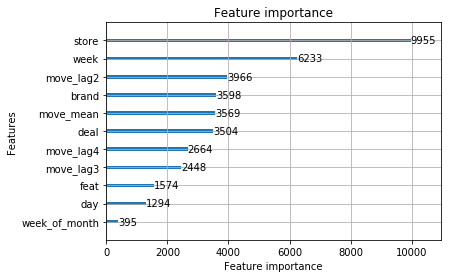

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=20)
plt.show()

Sample MAPE is 24.961475406228118
Sample MAPE is 51.275736072175334
Sample MAPE is 56.91704932167405
Sample MAPE is 65.46620810037146
Sample MAPE is 28.952848132224478


<Figure size 432x288 with 0 Axes>

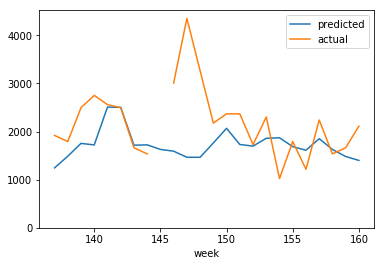

<Figure size 432x288 with 0 Axes>

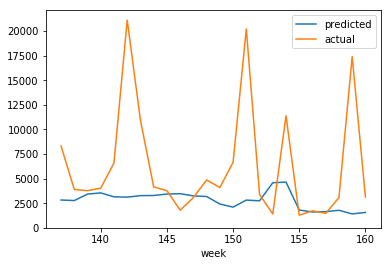

<Figure size 432x288 with 0 Axes>

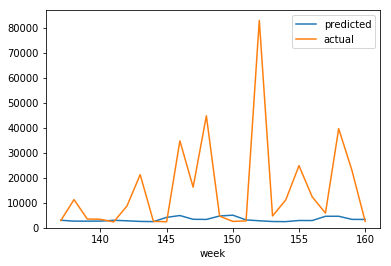

<Figure size 432x288 with 0 Axes>

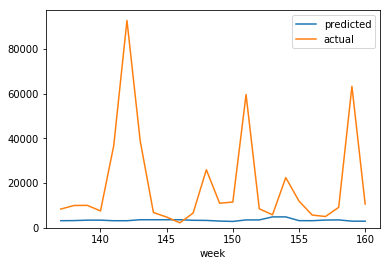

<Figure size 432x288 with 0 Axes>

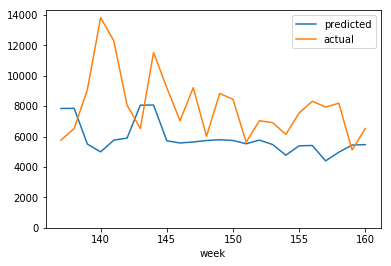

In [8]:
# Visualize forecast results
results = pd.concat(combined_all, axis=0)
for _ in range(5):
    store = random.choice(results['store'].unique())
    brand = random.choice(results['brand'].unique())
    plot_result(results, store, brand)